# PFAS Synthetic Landfill Emissions Analysis (LS - Landfill Synthetic)

Tools for simulating, analyzing, and mapping landfill methane (CH₄) and PFAS emissions using **synthetic landfill configurations**, synthetic receptor grids, Gaussian dispersion modeling, and geospatial analysis.

## Overview

This Jupyter notebook presents a controlled analysis of **Per- and Polyfluoroalkyl Substances (PFAS)** emissions from a **synthetic square landfill** with standardized characteristics. Unlike the real-world L19 and L26 landfill analyses, this notebook uses an **idealized geometric landfill configuration** to study emission patterns under controlled conditions and validate atmospheric dispersion modeling approaches.

The synthetic landfill approach allows for:
- **Controlled experimentation** with standardized geometric properties (square landfill with area = 353,699.4 m²)
- **Method validation** using simplified boundary conditions
- **Baseline comparison** for real-world landfill analyses
- **Educational demonstrations** of PFAS dispersion modeling principles

The codebase includes utilities to generate synthetic receptor measurements, compute fluxes and emission rates, apply quartile-based spatial analysis, convert model coordinates to geographic latitude/longitude, and visualize results on interactive web maps.

## Key Components

### 🎯 Objectives

- **Validate PFAS emission modeling** using controlled synthetic landfill geometry
- Model atmospheric dispersion patterns using Gaussian plume theory with idealized boundary conditions
- Demonstrate concentration field analysis using standardized square landfill (353,699.4 m² area)
- Develop and test quartile-based spatial analysis methods for emission assessment
- Generate reference visualizations and maps for method comparison and validation
- Provide educational framework for understanding PFAS dispersion modeling principles

### 📊 Data Sources

- **Synthetic square landfill**: Standardized geometric configuration with controlled area and emission parameters
- **Statistical meteorological data**: Median wind conditions (speed: 2.78 m/s, direction: 170°, stability class: B)
- **Standardized emission parameters**: Mean emission rate of 8.49 μg/s based on empirical landfill data
- **Controlled grid system**: 10 km × 10 km synthetic receptor grid for systematic sampling

## Methodology

### 🔬 Core Modeling

- **Gaussian Plume Modeling**  
  Calculates pollutant concentrations using standardized meteorological parameters and controlled geometric dispersion.

- **Synthetic Receptor Grid Generation**  
  Creates systematic monitoring points across a 10 km × 10 km domain to validate modeling approaches under controlled conditions.

- **Idealized Source Configuration**  
  Models emissions from a centered square landfill source within a standardized grid system for method validation.

- **Coordinate Transformations**  
  Converts between local Cartesian coordinates (x, y in meters) and geographic coordinates (lat, lon) using synthetic centroids and linearized metric–degree factors.

- **Controlled Analysis Framework**  
  Evaluates concentration patterns under standardized conditions to establish baseline performance and validate analytical methods.

### 📈 Analysis Features

- **Synthetic concentration mapping** under controlled meteorological conditions
- **Standardized coordinate system** for method validation and comparison
- **Statistical analysis** of concentration distributions using quartile-based classification
- **Geometric validation** of dispersion models using idealized square landfill boundaries
- **Reference visualizations** with:
  - Synthetic landfill geometry (square configuration)
  - Controlled emission sources and systematic receptor placement
  - Standardized grid boundaries and coordinate systems
- **Method validation** through controlled parameter analysis
- **Educational demonstrations** of PFAS dispersion modeling principles

## Geospatial and Synthetic Hull Utilities

The repository includes tools to:

- Generate **synthetic square landfill geometry** with controlled area (353,699.4 m²) and standardized positioning
- Create **idealized convex hull** boundaries for method validation and comparison
- Overlay synthetic geometry on:
  - Matplotlib figures (concentration fields, source locations)
  - Interactive web maps for visualization and validation
- **Compare synthetic vs. real-world** landfill geometries for method assessment
- **Validate coordinate transformation** algorithms using controlled geometric boundaries

## Visualization Outputs

### 🗺️ Maps and Plots

- **Synthetic concentration contour maps** for controlled meteorological scenarios
- **Method validation visualizations** with:
  - Idealized square landfill geometry
  - Systematic receptor grid patterns
  - Standardized coordinate system overlays
  - Controlled emission source configurations
- **Comparative analysis plots** showing synthetic vs. real-world modeling approaches
- **Educational visualizations** demonstrating PFAS dispersion principles
- **Statistical validation plots** and quartile-based concentration analysis

## Applications

### 💡 Use Cases

- **Method validation and verification** for atmospheric dispersion modeling approaches
- **Educational tool** for understanding PFAS transport and fate modeling principles  
- **Benchmark reference** for comparing real-world landfill analysis results
- **Algorithm development** for emission source characterization and receptor optimization
- **Scientific research** baseline for PFAS dispersion model validation and sensitivity analysis
- **Regulatory tool development** using controlled scenarios for policy assessment

## Repository Structure (Indicative)

- `notebooks/`  
  Jupyter notebooks implementing synthetic landfill PFAS analysis and method validation frameworks.

- `data/`  
  Input data files (synthetic parameter configurations, standardized weather data, validation datasets).

- `src/`  
  Python modules for:
  - Gaussian dispersion calculations with controlled parameters.
  - Synthetic landfill geometry generation and receptor grid optimization.
  - Coordinate transformations for idealized geometric configurations.
  - JSON export of synthetic parameters and validation results.
  - Mapping utilities for method validation visualizations.

- `README.md`  
  Project overview, synthetic methodology, and validation procedures.

---

**Note**: This analysis provides a **controlled framework** for validating PFAS emission modeling methodologies using synthetic landfill configurations. The idealized geometric approach enables method verification, educational demonstrations, and baseline establishment for comparing real-world landfill analyses such as L19 and L26.

## Preamble

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.path import Path  # For point-in-polygon (hull)
from scipy.spatial import ConvexHull
import json

## Input data

Hull vertices for each landfill.


In [83]:
xls_path = "../data/Convex_Hull_Table.xls"

# Read each sheet separately
wake_df    = pd.read_excel(xls_path, sheet_name="Wake")
hanover_df = pd.read_excel(xls_path, sheet_name="Hanover")

# Extract coordinates as NumPy arrays [lat, lon]
convex_hull_wake    = wake_df[["Latitude", "Longitude"]].to_numpy()
convex_hull_hanover = hanover_df[["Latitude", "Longitude"]].to_numpy()

In [84]:
# Compute the centroid of the convex hull
centroid_w = convex_hull_wake.mean(axis=0)
print(f"Centroid of  convex hull:")
print(f"Latitude: {centroid_w[0]:.6f},  Longitude: {centroid_w[1]:.6f}")

Centroid of  convex hull:
Latitude: 35.676091,  Longitude: -78.847150


In [85]:
landfill = 'LFS_PS'

| Parameter | Statistic | Value | Unit |
|-----------|-----------|-------|------|
| Wind Speed | Median | 2.78 | m/s |
| Wind Direction | Median | 170 | Degrees |
| Stability Class | Computed with Wind Speed | B | |
| Emission Rate | Mean | 8.493941135 | ug/s |
| Area | Median | 353699.4 | m² |

### Grid vertices
We use a 10 km squared grid

In [86]:
x_lim = 10_000
y_lim = 10_000
hull_vertices= np.array([[0,0],[0,y_lim],[x_lim,y_lim],[x_lim,0]]) # This hull correspond to the grid limits

In [87]:
# Desired area of the (square) synthetic landfill
area = 353_699.4
# Side length of the square landfill
side = np.sqrt(area)

if side > min(x_lim, y_lim):
    raise ValueError("Requested landfill area is too large for the grid.")

# Place the square in the center of the grid
x0 = (x_lim - side) / 2.0
y0 = (y_lim - side) / 2.0

# Square convex hull for the synthetic landfill
landfill_convex_hull = np.array([
    [x0,      y0     ],
    [x0,      y0+side],
    [x0+side, y0+side],
    [x0+side, y0     ]
])

### Weather data

In [88]:
weather_df = pd.DataFrame(
    [
        [
            1,                      # Index
            1,                      # Weather_Index
            "2021-07-01",            # Date (Q3 representative)
            2021,                   # Year
            "Q3",                   # Quarter
            1,                      # Weather_Index (duplicated, intentional)
            2.78,                   # Wind_Speed (m/s)
            170.0,                  # Wind_Direction (degrees)
            np.nan,                 # Temperature
            "B",                    # Class (Stability Class)
        ]
    ],
    columns=[
        "Index",
        "Weather_Index",
        "Date",
        "Year",
        "Quarter",
        "Weather_Index",   # duplicated column preserved
        "Wind_Speed",
        "Wind_Direction",
        "Temperature",
        "Class",
    ]
)

# Convert Date to datetime
weather_df["Date"] = pd.to_datetime(weather_df["Date"])

weather_df

,Index,Weather_Index,Date,Year,Quarter,Weather_Index,Wind_Speed,Wind_Direction,Temperature,Class
0,1,1,2021-07-01,2021,Q3,1,2.78,170.0,NaN,B


### Params

In [89]:
emissions_rate_micrograms_per_second = 8.493941135

## Functions

In [90]:
def s_point_in_hull(point, hull_vertices, margin=50):
    """
    Returns True if the point is inside the polygon defined by hull_vertices,
    considering a minimum margin from the edge (inward).
    
    Parameters
    ----------
    point : array-like (2,)
        Point to test [x, y].
    hull_vertices : array-like (n, 2)
        Convex polygon vertices.
    margin : float
        Minimum distance from the edge (in meters). If > 0, the point must be at least
        'margin' meters inside the polygon to be considered True.

    Returns
    -------
    is_inside : bool
        True if point is inside the polygon with the specified internal margin.
    """
    poly = Path(hull_vertices)
    return poly.contains_point(point, radius=-margin)


# Generate valid points
def generate_valid_points(width, height, hull_vertices, granularity=7):
    x_coords = np.arange(0, width + granularity, granularity)
    y_coords = np.arange(0, height + granularity, granularity)
    grid_x, grid_y = np.meshgrid(x_coords, y_coords)
    candidate_points = np.column_stack((grid_x.ravel(), grid_y.ravel()))
    valid_points = [point for point in candidate_points if is_point_in_hull(point, hull_vertices)]
    return np.array(valid_points)


def generate_serpentine_receptors(x_min, x_max, y_min, y_max, step_x, step_y, hull_vertices, eps=30):
    """
    Generates receptors in a serpentine pattern with independent granularity in x and y,
    respecting the landfill polygon (hull_vertices) and maintaining a minimum margin eps
    from the edges.
    
    Parameters
    ----------
    x_min, x_max, y_min, y_max : float
        Rectangular limits enclosing the polygon.
    step_x, step_y : float
        Grid resolution in x and y (m).
    hull_vertices : array-like (n,2)
        Coordinates of the landfill polygon vertices.
    eps : float
        Minimum distance to the edges in meters (internal margin).

    Returns
    -------
    receptor_df : pd.DataFrame with columns ['receptor_id','x(m)','y(m)']
    """
    # Ensure non-negative values
    x_min = max(0.0, float(x_min))
    y_min = max(0.0, float(y_min))
    x_max = float(x_max)
    y_max = float(y_max)
    step_x = float(step_x)
    step_y = float(step_y)
    eps = float(eps)

    if step_x <= 0 or step_y <= 0:
        raise ValueError("step_x and step_y must be positive.")

    # Create coordinates excluding borders + margin eps
    x_coords = np.arange(x_min + step_x, x_max, step_x)
    y_coords = np.arange(y_min + step_y, y_max, step_y)

    # Complete grid
    grid_x, grid_y = np.meshgrid(x_coords, y_coords)
    points = np.column_stack((grid_x.ravel(), grid_y.ravel()))

    # Filter only points within the polygon with margin eps
    poly = Path(hull_vertices)
    mask = poly.contains_points(points, radius=-eps)  # radius<0 excludes edge, here we use -eps
    inside_points = points[mask]

    # Serpentine order by y row
    serpentine_points = []
    for i, y in enumerate(y_coords):
        row = inside_points[np.isclose(inside_points[:, 1], y, atol=1e-9)]
        if row.size == 0:
            continue
        order = np.argsort(row[:, 0])
        if i % 2 == 1:
            order = order[::-1]
        serpentine_points.extend(row[order])

    serpentine_points = np.array(serpentine_points)
    serpentine_points = np.round(serpentine_points, 1)

    receptor_df = pd.DataFrame({
        "receptor_id": np.arange(1, len(serpentine_points) + 1, dtype=int),
        "x(m)": serpentine_points[:, 0],
        "y(m)": serpentine_points[:, 1]
    })

    return receptor_df


def assign_days_same_quarter(
    df,
    n_days,
    weather_df,
    day_col="Index",
    index_col="Index",
    quarter_col="Quarter",
    seed=None,
    replace=False
    ):
    """
    Assign contiguous receptor chunks to day IDs drawn from a SINGLE quarter
    randomly chosen from `weather_df[quarter_col]`. 
    We use single quarter to ensure meteorological consistency.
    Returns (out_df, used_quarter).
    """
    if n_days <= 0:
        raise ValueError("n_days must be positive.")
    if df.empty:
        return df.assign(**{day_col: []}), None

    rng = np.random.default_rng(seed)

    # Pick a quarter at random from available quarters
    available_quarters = pd.unique(weather_df[quarter_col])
    if len(available_quarters) == 0:
        raise ValueError("weather_df contains no quarters.")
    used_quarter = rng.choice(available_quarters)
    print(f"Chosen quarter for assignment: {used_quarter}")
    # Day IDs from the chosen quarter
    quarter_days = weather_df.loc[
        weather_df[quarter_col] == used_quarter, index_col
    ].unique()

    if len(quarter_days) == 0:
        raise ValueError(f"No day IDs found for quarter {used_quarter}.")
    if not replace and len(quarter_days) < n_days:
        raise ValueError(
            f"Quarter {used_quarter} has only {len(quarter_days)} unique day IDs; "
            f"n_days={n_days}. Set replace=True or reduce n_days."
        )

    # Randomly choose day IDs
    #chosen_ids = rng.choice(quarter_days, size=n_days, replace=replace) XXX
    chosen_ids = weather_df[index_col].to_numpy()



    # Build contiguous chunk indices 0..n_days-1
    N = len(df)
    base, rem = divmod(N, n_days)
    chunk_idx = np.empty(N, dtype=int)
    start = 0
    for i in range(n_days):
        size = base + (1 if i < rem else 0)
        end = start + size
        chunk_idx[start:end] = i
        start = end

    # Map chunk index -> chosen day id
    mapping = {i: int(chosen_ids[i]) for i in range(n_days)}
    assigned = np.vectorize(mapping.get)(chunk_idx)
    print("Chosen day_ids for assignment:", ", ".join(map(str, chosen_ids)), "\n")

    out = df.copy()
    out[day_col] = assigned
    return out



def random_source_creator(
    hull_vertices,
    n_sources_range=(1, 8),
    num_sources=None,
    random_num_sources=True,
    emission_range=(100_000, 10_000_000),
    seed=42
):
    """
    Uniformly samples source positions inside a convex polygon
    (landfill hull) using area-weighted triangulation.
    Emissions are sampled from a clipped normal distribution.

    Returns
    -------
    sources : np.ndarray (n_sources, 3)
        Rows are [x, y, Q], all guaranteed inside the hull.
    """
    if hull_vertices is None or len(hull_vertices) < 3:
        raise ValueError("hull_vertices must be an array (n_vertices >= 3, 2).")

    rng = np.random.default_rng(seed)

    # ------------------------------------------------------------
    # Number of sources
    # ------------------------------------------------------------
    if random_num_sources:
        n_sources = int(rng.integers(n_sources_range[0], n_sources_range[1] + 1))
    else:
        if num_sources is None or not isinstance(num_sources, int) or num_sources < 1:
            raise ValueError("If random_num_sources=False, provide num_sources as int > 0.")
        n_sources = int(num_sources)

    # ------------------------------------------------------------
    # Prepare polygon
    # ------------------------------------------------------------
    poly = np.asarray(hull_vertices, dtype=float)
    path = Path(poly)

    # ------------------------------------------------------------
    # Triangulation fan (valid for convex polygons)
    # ------------------------------------------------------------
    v0 = poly[0]
    triangles = []
    areas = []

    for i in range(1, len(poly) - 1):
        a = v0
        b = poly[i]
        c = poly[i + 1]

        triangles.append(np.array([a, b, c]))

        # NumPy 2.0–safe 2D cross product (scalar)
        u = b - a
        v = c - a
        cross2d = u[0] * v[1] - u[1] * v[0]
        areas.append(0.5 * abs(cross2d))

    areas = np.asarray(areas, dtype=float)

    if not np.all(areas > 0):
        raise ValueError("Degenerate triangles detected. Check hull_vertices ordering.")

    probs = areas / areas.sum()

    # ------------------------------------------------------------
    # Helper: uniform sampling inside a triangle
    # ------------------------------------------------------------
    def sample_point_in_triangle(tri):
        r1 = rng.random()
        r2 = rng.random()
        if r1 + r2 > 1.0:
            r1 = 1.0 - r1
            r2 = 1.0 - r2
        a, b, c = tri
        return a + r1 * (b - a) + r2 * (c - a)

    # ------------------------------------------------------------
    # Sample positions
    # ------------------------------------------------------------
    XY = np.empty((n_sources, 2), dtype=float)

    for k in range(n_sources):
        while True:
            idx = rng.choice(len(triangles), p=probs)
            p = sample_point_in_triangle(triangles[idx])
            # Safety check (should always pass for convex hulls)
            if path.contains_point(p):
                XY[k] = p
                break

    # ------------------------------------------------------------
    # Sample emissions Q
    # ------------------------------------------------------------
    Q_min, Q_max = emission_range
    Q_mean = 0.5 * (Q_min + Q_max)
    Q_std = (Q_max - Q_min) / 6.0

    Q = np.clip(
        rng.normal(Q_mean, Q_std, size=n_sources),
        Q_min,
        Q_max
    )

    return np.column_stack([XY, Q])



def generate_receptor_concentrations_by_day(
    receptor_df,
    weather_df,
    sources,
    stability_col="Class",
    wind_speed_col="Wind_Speed",
    wind_dir_col="Wind_Direction",
    day_col="Index",
    bg_concentration=5
):
    """
    Computes receptor concentrations using a fixed source configuration across all
    weather days, with day-specific meteorological conditions.

    Parameters
    ----------
    receptor_df : pd.DataFrame
        Must contain receptor coordinates and a day identifier column.
    weather_df : pd.DataFrame
        Meteorological data per day, with wind direction, speed, and stability class.
    sources : np.ndarray (n_sources, 3)
        Source array [x, y, Q] to apply across all days.
    stability_col, wind_speed_col, wind_dir_col : str
        Column names in weather_df for Pasquill class, wind speed, and wind direction.
    day_col : str
        Column in receptor_df indicating assigned day.
    bg_concentration : float
        Background concentration to subtract (in ng/m³ of PFAS).

    Returns
    -------
    final_df : pd.DataFrame
        Original receptor_df with an added 'concentration(ngm3)' column.
    """
    results = []
    grouped = receptor_df.groupby(day_col)

    for day_id, group in grouped:
        met_row = weather_df.loc[weather_df[day_col] == day_id]
        if met_row.empty:
            print(f"[Warning] No weather data for day {day_id}")
            continue
        met_row = met_row.squeeze()

        wind_speed = float(met_row[wind_speed_col])
        wind_rad = np.radians(float(met_row[wind_dir_col]))
        stability = str(met_row[stability_col])

        # Subset of receptors for this day
        receptors_xy = group[['x(m)', 'y(m)']].to_numpy()
        print(f"Wind speed: {wind_speed}, Wind rad: {wind_rad}, Stability: {stability}, Wind degree: {met_row[wind_dir_col]}, Num receptors: {len(receptors_xy)}")

        concs = calculate_total_concentrations(
            sources=sources,
            receptors=receptors_xy,
            wind_rad=wind_rad,
            wind_speed=wind_speed,
            stability_class_char=stability
        )

        # ------------------------------------------------------------
        # Background subtraction: if conc ≤ bg_concentration → 0
        # otherwise conc - bg_concentration
        # ------------------------------------------------------------

        concs = np.where(
            concs <= bg_concentration,
            0.0,
            concs - bg_concentration
        )
        

        group = group.copy() # Avoid SettingWithCopyWarning
        group["concentration(ngm3)"] = concs
        results.append(group)

    return pd.concat(results, ignore_index=True), sources



def calculate_total_concentrations(
    sources, receptors, wind_rad, wind_speed, stability_class_char
):
    """
    Calculates the total concentration at each receptor from all emission sources,
    using wind-aligned coordinates via meteorological convention.

    Parameters
    ----------
    sources : ndarray (n_sources, 3)
        Source coordinates and emission rates [x, y, Q] in µg/s.
    receptors : ndarray (n_receptors, 2)
        Receptor coordinates [x, y].
    wind_rad : float
        Wind direction in radians (meteorological convention: from which wind blows).
    wind_speed : float
        Wind speed in m/s.
    stability_class_char : str
        Pasquill-Gifford stability class ('A' to 'F').
    Returns
    -------
    total_concs : ndarray (n_receptors,)
        Concentrations at each receptor are calculated in µg/m³ and then translated into ng//m³.

    """
    def rotate_coordinates_2(x, y, wind_angle_deg):
        """
        Rotate coordinates based on the wind direction, aligning x' and y' as per wind conventions.
        """
        angle_radians = np.radians(90 - wind_angle_deg + 180)
        x_rot = x * np.cos(angle_radians) + y * np.sin(angle_radians)
        y_rot = -x * np.sin(angle_radians) + y * np.cos(angle_radians)
        return x_rot, y_rot

    # Convert wind direction to degrees for rotation function
    wind_deg = np.degrees(wind_rad)

    total_concs = np.zeros(len(receptors))
    for i in range(sources.shape[0]):
        sx, sy, Q = sources[i]
        for j in range(receptors.shape[0]):
            rx, ry = receptors[j]

            dx = rx - sx
            dy = ry - sy

            dx_rot, dy_rot = rotate_coordinates_2(dx, dy, wind_deg)

            if dx_rot > 0:
                sigma_y, sigma_z = get_briggs_coeffs(stability_class_char, dx_rot)
                if sigma_y > 0 and sigma_z > 0:
                    total_concs[j] += (
                        Q
                        / (np.pi * wind_speed * sigma_y * sigma_z)
                        * np.exp(-0.5 * (dy_rot / sigma_y) ** 2)
                    )

    return total_concs * 1000 # Convert from µg/m³ to ng/m³



def get_briggs_coeffs(stability_class_char, x):
    """Calculates dispersion coefficients using Pasquill-Gifford-Turner formulas."""
    x = max(x, 1e-6)

    if stability_class_char == 'A':
        a_y, b_y, a_z, b_z = 0.22, 0.0001, 0.20, 0.0
    elif stability_class_char == 'B':
        a_y, b_y, a_z, b_z = 0.16, 0.0001, 0.12, 0.0
    elif stability_class_char == 'C':
        a_y, b_y, a_z, b_z = 0.11, 0.0001, 0.08, 0.0002
    elif stability_class_char == 'D':
        a_y, b_y, a_z, b_z = 0.08, 0.0001, 0.06, 0.0015
    elif stability_class_char == 'E':
        a_y, b_y, a_z, b_z = 0.06, 0.0001, 0.03, 0.0003
    else:  # Defaults to 'F' for jit compatibility
        a_y, b_y, a_z, b_z = 0.04, 0.0001, 0.016, 0.0003

    sigma_y = a_y * x * (1.0 + b_y * x) ** -0.5
    if b_z == 0.0:
        sigma_z = a_z * x
    else:
        sigma_z = a_z * x * (1.0 + b_z * x) ** -0.5

    return sigma_y, sigma_z

## Synthetic receptors data generation

### Parameters

In [91]:
# Landfill bounds

x_min, x_max = hull_vertices[:, 0].min(), hull_vertices[:, 0].max() # X bounds (m)
y_min, y_max = hull_vertices[:, 1].min(), hull_vertices[:, 1].max() # Y bounds (m)
landfill_width = x_max - x_min  # Width (m)
landfill_height = y_max - y_min  # Height (m)

step_x, step_y = 20, 20  # Grid spacing in x and y axis (m)

### Receptor Grid Generation

In [92]:
receptor_df = generate_serpentine_receptors(x_min=x_min, x_max=x_max, 
                                            y_min=y_min, y_max=y_max,  
                                            step_x=step_x, step_y=step_y,
                                            hull_vertices=hull_vertices)
print(f"Generated {len(receptor_df)} receptors.\n")
print(receptor_df.head())
print('Grid number of receptors:', len(receptor_df))

Generated 249001 receptors.

   receptor_id   x(m)  y(m)
0            1   20.0  20.0
1            2   40.0  20.0
2            3   60.0  20.0
3            4   80.0  20.0
4            5  100.0  20.0
Grid number of receptors: 249001


### Assign different measurement days to the receptors

In [93]:
weather_df.iloc[[0]]  # we use the same weather day as emision JSON file

,Index,Weather_Index,Date,Year,Quarter,Weather_Index,Wind_Speed,Wind_Direction,Temperature,Class
0,1,1,2021-07-01,2021,Q3,1,2.78,170.0,NaN,B


In [94]:
# We can define the number of days here both randomly or fixed
n_days = 1 #random.choice([1, 2, 3, 4, 5, 6, 7])
print(f"Selected n_days: {n_days}")

receptor_day_df_0 = assign_days_same_quarter(
    receptor_df,
    n_days=n_days,
    weather_df=weather_df.iloc[[0]],
    seed=None
)

Selected n_days: 1
Chosen quarter for assignment: Q3
Chosen day_ids for assignment: 1 



### Visualizing receptors per day, and adding emission sources

The function `s_point_in_hull` ensures that the sources created at random positions remain within the boundaries of the landfill. The function defines an internal margin (50 m by default) within which no emitting sources can be placed. 

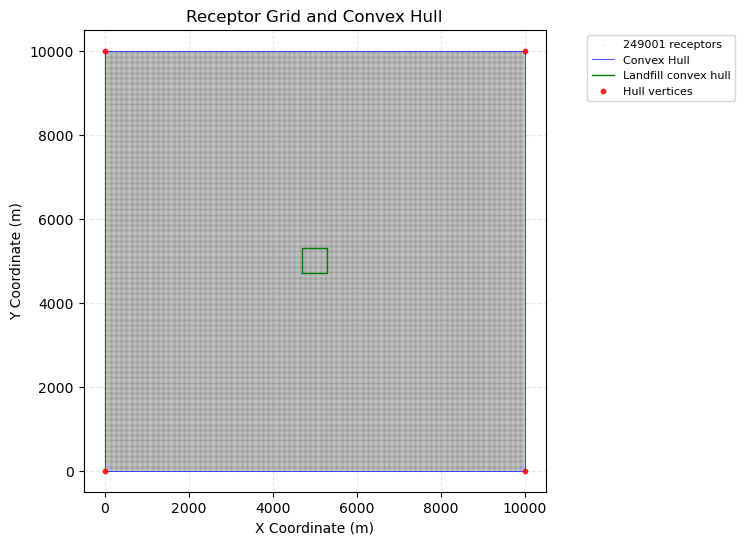

In [95]:
from matplotlib import cm
from scipy.spatial import ConvexHull

# Expecting receptor_df with columns ['receptor_id','x(m)','y(m)']
receptor_points = receptor_df[['x(m)', 'y(m)']].to_numpy()

# Optional grouping by day_index (from previous steps). Otherwise no grouping.
use_groups = 'day_index' in globals() and len(day_index) == len(receptor_points)
if use_groups:
    groups = np.unique(day_index)
    colors = cm.viridis(np.linspace(0, 1, groups.size))
    color_map = {g: c for g, c in zip(groups, colors)}


axis_min = min(x_min, y_min)  # Smallest bound across both axes
axis_max = max(x_max, y_max)  # Largest bound across both axes
pad = 500

plt.figure(figsize=(6, 6))

# Scatter receptors
if use_groups:
    for g in groups:
        mask = (day_index == g)
        plt.scatter(receptor_points[mask, 0], receptor_points[mask, 1],
                    color=color_map[g], alpha=0.1, marker='x', s=1,
                    label=f'Day {int(g)+1}')
else:
    plt.scatter(receptor_points[:, 0], receptor_points[:, 1],
                marker='x', color='gray', s=1, alpha=0.1, label=f'{len(receptor_points)} receptors')
# Convex hull
closed = np.vstack([hull_vertices, hull_vertices[0]])
plt.plot(closed[:, 0], closed[:, 1], color='blue', lw=0.5, label='Convex Hull')

# Kandfill convex hull
landfill_closed = np.vstack([landfill_convex_hull, landfill_convex_hull[0]])
plt.plot(
    landfill_closed[:, 0],
    landfill_closed[:, 1],
    color='green', lw=1.0,
    label='Landfill convex hull',
    zorder=6
)


# Hull vertices
plt.scatter(hull_vertices[:, 0], hull_vertices[:, 1],
            color='red', s=10, alpha=0.8, label='Hull vertices', zorder=5)

# Formatting
plt.title('Receptor Grid and Convex Hull')
plt.xlabel('X Coordinate (m)')
plt.ylabel('Y Coordinate (m)')
plt.grid(True, alpha=0.3, linestyle='--')
plt.gca().set_aspect('equal', adjustable='box')

plt.xlim(x_min - pad, x_max + pad)
plt.ylim(y_min - pad, y_max + pad)
# plt.xticks(np.arange(0, 1001, 250))
# plt.yticks(np.arange(0, 1751, 250))
plt.legend(loc='upper center', bbox_to_anchor=(1.25, 1.0), fontsize=8)
plt.show()

In [96]:
sources = np.array([[5000, 5000, emissions_rate_micrograms_per_second]])

print("Sources :\n", sources)


Sources :
 [[5000.         5000.            8.49394114]]


### Visualizing the sources

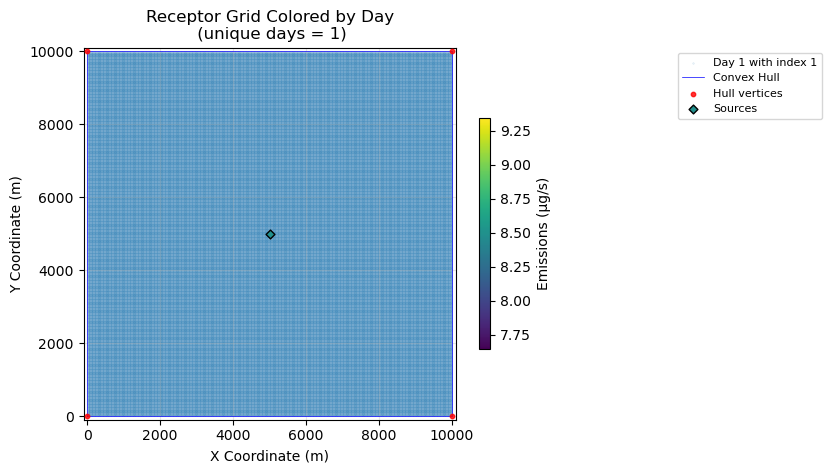

In [97]:
# Visualization
receptor_points = receptor_day_df_0[['x(m)', 'y(m)']].to_numpy()

# --- Discover distinct days from the DataFrame ---
days = np.array(sorted(receptor_day_df_0['Index'].unique()))
n_days = len(days)
colors = plt.get_cmap('tab10')(np.arange(n_days))
color_map = {d: c for d, c in zip(days, colors)}

# --- Axis range from polygon (symmetric padding) ---
x_min, x_max = hull_vertices[:, 0].min(), hull_vertices[:, 0].max()
y_min, y_max = hull_vertices[:, 1].min(), hull_vertices[:, 1].max()
axis_min = min(x_min, y_min)
axis_max = max(x_max, y_max)
pad = 100

# --- Plot ---
plt.figure(figsize=(6, 6))

# Points by actual day values from receptor_df
for i, d in enumerate(days):
    mask = (receptor_day_df_0['Index'] == d).to_numpy()
    plt.scatter(receptor_points[mask, 0], receptor_points[mask, 1],
                color=color_map[d], alpha=0.1, marker='x', s=1,
                label=f'Day {i+1} with index {d}')

# Convex hull polygon from provided vertices
closed = np.vstack([hull_vertices, hull_vertices[0]])
plt.plot(closed[:, 0], closed[:, 1], color='blue', lw=0.5, label='Convex Hull')
plt.scatter(hull_vertices[:, 0], hull_vertices[:, 1],
            color='red', s=10, alpha=0.8, label='Hull vertices', zorder=5)
# Sources
plt.scatter(sources[:, 0], sources[:, 1], c=sources[:, 2], cmap='viridis', s=20, marker='D', edgecolor='black', label='Sources')

# Formatting
plt.title(f'Receptor Grid Colored by Day\n (unique days = {n_days})')
plt.xlabel('X Coordinate (m)')
plt.ylabel('Y Coordinate (m)')
plt.grid(True, alpha=0.3)
plt.gca().set_aspect('equal', adjustable='box')

plt.xticks(np.arange(0, 10001, 2000))
plt.yticks(np.arange(0, 10001, 2000))
plt.xlim(x_min - pad, x_max + pad)
plt.ylim(y_min - pad, y_max + pad)
plt.legend(loc='upper right', bbox_to_anchor=(2.0, 1.0), fontsize=8)
plt.colorbar(label='Emissions (µg/s)', shrink=0.5) 
#plt.savefig("../img/receptor_grid_by_day.png", dpi=300, bbox_inches='tight')
plt.show()

In [98]:
synthetic_df_0, sources_0 = generate_receptor_concentrations_by_day(
    receptor_df=receptor_day_df_0,
    weather_df=weather_df.iloc[[0]],
    sources=sources,
    wind_speed_col="Wind_Speed",
    wind_dir_col="Wind_Direction",
    stability_col="Class",
    day_col="Index",
    bg_concentration=0 #, pfas_bg_conc_ppm, # 0.000175 ppm
)

Wind speed: 2.78, Wind rad: 2.9670597283903604, Stability: B, Wind degree: 170.0, Num receptors: 249001


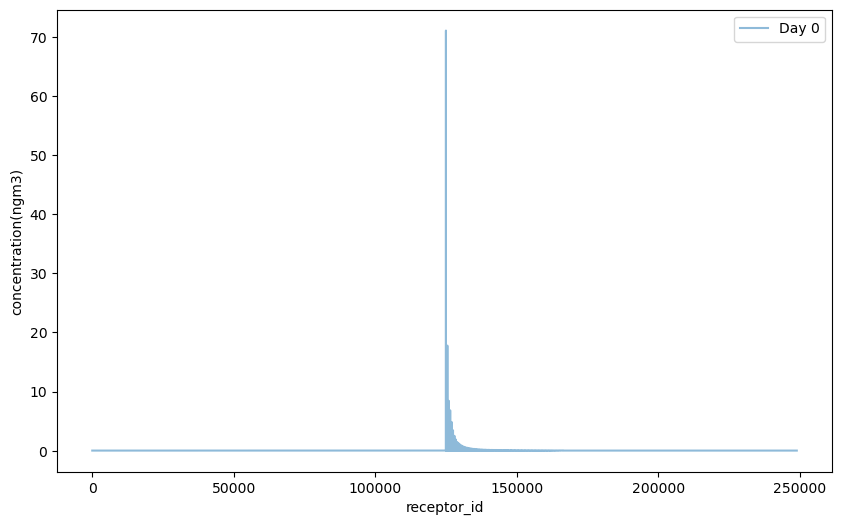

In [99]:
plt.figure(figsize=(10, 6))

for i, df in enumerate([synthetic_df_0]):
    plt.plot(
        df["receptor_id"],
        df["concentration(ngm3)"],
        alpha=0.5,
        label=f"Day {i}"
    )

plt.xlabel("receptor_id")
plt.ylabel("concentration(ngm3)")
plt.legend()
# plt.yscale("log")

plt.show()

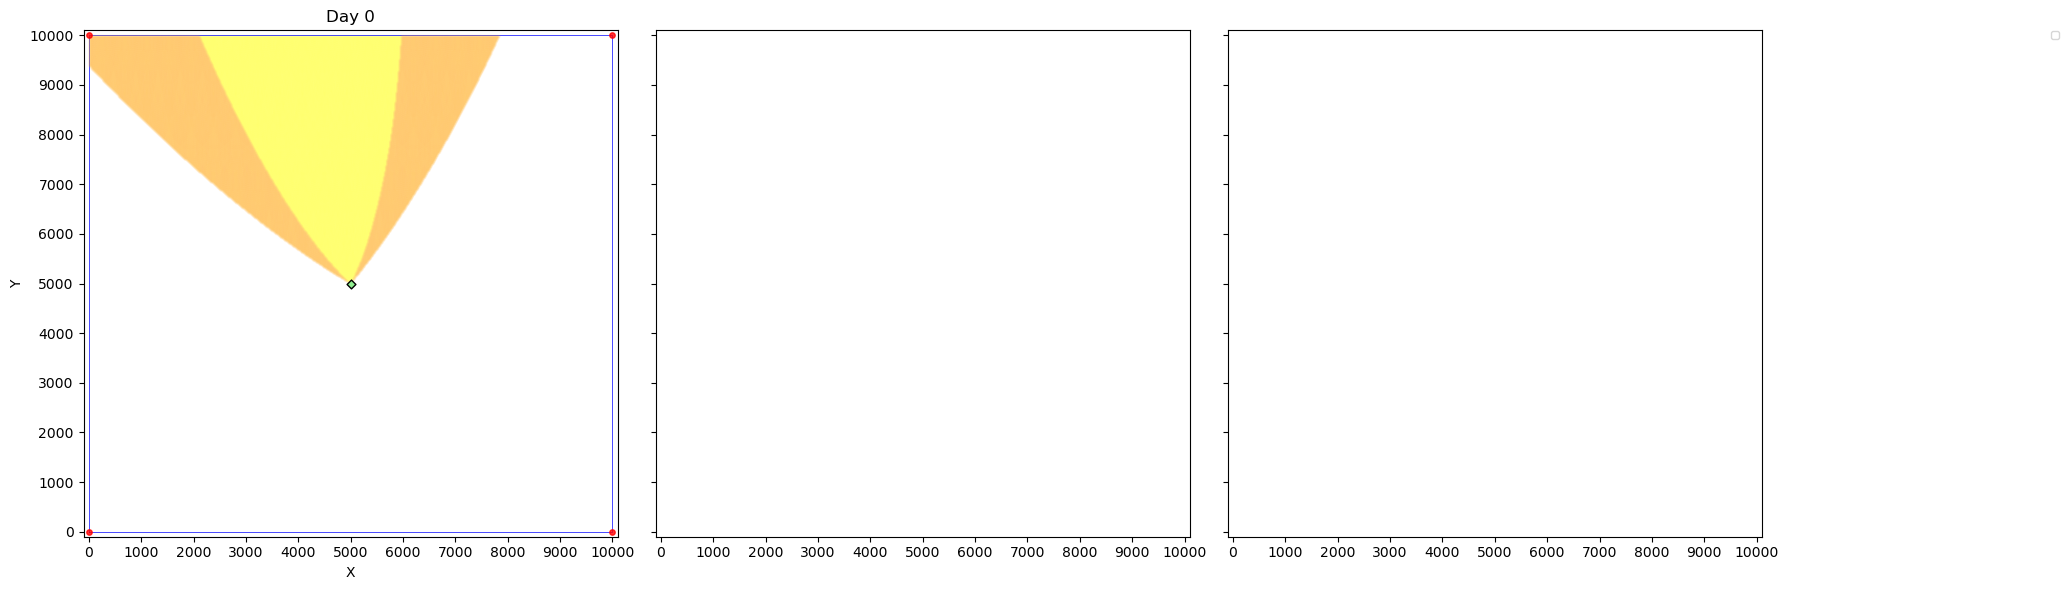

In [100]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
synthetic_list = [synthetic_df_0]
sources = [sources]
titles = ["Day 0", "Day 1", "Day 2"]
closed = np.vstack([hull_vertices, hull_vertices[0]])

for ax, df, title, sources in zip(axes, synthetic_list, titles, sources):
    # --- Extract columns ---
    x = df['x(m)'].to_numpy()
    y = df['y(m)'].to_numpy()
    conc = df['concentration(ngm3)'].to_numpy()

    # --- Mask non-zero concentrations ---
    mask_nz = conc > 0
    x_nz = x[mask_nz]
    y_nz = y[mask_nz]
    c_nz = conc[mask_nz]

    ax.set_title(title)

    if c_nz.size == 0:
        ax.text(0.5, 0.5, "All concentrations = 0",
                ha="center", va="center", transform=ax.transAxes)
        continue

    # --- Quartiles (non-zero only) ---
    q1 = np.percentile(c_nz, 25)
    q2 = np.percentile(c_nz, 50)   # median
    q3 = np.percentile(c_nz, 75)

    # --- Quartile masks ---
    m_q1 = (c_nz <= q1)
    m_q2 = (c_nz > q1) & (c_nz <= q2)
    m_q3 = (c_nz > q2) & (c_nz <= q3)
    m_q4 = (c_nz > q3)

    # --- Base geometry: hull + sources ---
    ax.plot(closed[:, 0], closed[:, 1],
            color='blue', lw=0.5, label='Convex Hull')

    ax.scatter(
        hull_vertices[:, 0], hull_vertices[:, 1],
        color='red', s=15, alpha=0.8,
        label='Hull vertices', zorder=5
    )

    ax.scatter(
        sources[:, 0], sources[:, 1],
        c='lightgreen', s=20, marker='D',
        edgecolor='black', zorder=5,
        label='Sources'
    )

    # --- Receptors by quartile ---
    s = 5
    alpha = 0.1
    # ax.scatter(x_nz[m_q1], y_nz[m_q1], c="blue", linewidths=0, edgecolors="none",
    #            alpha=alpha, s=s, zorder=4, label="Q1 (0–25%)")
    # ax.scatter(x_nz[m_q2], y_nz[m_q2], c="red", linewidths=0, edgecolors="none",
    #            alpha=alpha, s=s, zorder=3, label="Q2 (25–50%)")
    ax.scatter(x_nz[m_q3], y_nz[m_q3], c="orange", linewidths=0, edgecolors="none",
               alpha=alpha, s=s, zorder=2, label="Q3 (50–75%)")
    ax.scatter(x_nz[m_q4], y_nz[m_q4], c="yellow", linewidths=0, edgecolors="none",
               alpha=alpha, s=s, zorder=1, label="Q4 (75–100%)")

    ax.set_xticks(np.arange(0, x_lim + 1, 1000))
    ax.set_yticks(np.arange(0, y_lim + 1, 1000))
    ax.set_xlim(x_min - pad, x_max + pad)
    ax.set_ylim(y_min - pad, y_max + pad)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

# Put a single legend outside (take handles from last axis)
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15, 0.95), fontsize=8)

plt.tight_layout()
plt.show()

In [101]:
# --------------------------------------------------------
# 1. Función genérica: distancia por cuartil para un dataset
# --------------------------------------------------------
def max_point_and_dist(x_nz, y_nz, c_nz, sources, mask, label):
    idxs = np.where(mask)[0]
    if idxs.size == 0:
        print(f"No points in {label}.")
        return None

    # 1) Max concentración dentro del cuartil
    local_max_idx = np.argmax(c_nz[idxs])
    global_idx = idxs[local_max_idx]

    x_max = x_nz[global_idx]
    y_max = y_nz[global_idx]
    c_max = c_nz[global_idx]

    # 2) Fuente asociada: la más cercana al punto de máxima concentración
    dists_to_sources = np.sqrt(
        (sources[:, 0] - x_max) ** 2 + (sources[:, 1] - y_max) ** 2
    )
    src_idx = np.argmin(dists_to_sources)
    sx, sy, _ = sources[src_idx]

    # 3) Distancia desde esa fuente al punto más lejano del cuartil
    x_q = x_nz[idxs]
    y_q = y_nz[idxs]
    dists_src_to_pts = np.sqrt((x_q - sx) ** 2 + (y_q - sy) ** 2)
    max_dist = dists_src_to_pts.max()

    print(
        f"{label}: max conc={c_max:.3e} at (x={x_max:.2f}, y={y_max:.2f}), "
        f"assigned source index={src_idx}, farthest point distance={max_dist:.2f} m"
    )

    return max_dist


def quartile_distances_for_df(synthetic_df, sources):
    """
    Calcula d_q1, d_q2, d_q3, d_q4 para un synthetic_df dado.
    Devuelve un dict con las distancias por cuartil.
    """
    # Extrae columnas y filtra concentraciones > 0
    x = synthetic_df['x(m)'].to_numpy()
    y = synthetic_df['y(m)'].to_numpy()
    conc = synthetic_df['concentration(ngm3)'].to_numpy()

    mask_nz = conc > 0
    x_nz = x[mask_nz]
    y_nz = y[mask_nz]
    c_nz = conc[mask_nz]

    if c_nz.size == 0:
        print("All concentrations are zero in this dataset.")
        return {"Q1": None, "Q2": None, "Q3": None, "Q4": None}

    # Quartiles
    q1 = np.percentile(c_nz, 25)
    q2 = np.percentile(c_nz, 50)   # mediana
    q3 = np.percentile(c_nz, 75)

    m_q1 = (c_nz <= q1)
    m_q2 = (c_nz > q1) & (c_nz <= q2)
    m_q3 = (c_nz > q2) & (c_nz <= q3)
    m_q4 = (c_nz > q3)

    # Distancias por cuartil (pueden ser None si no hay puntos)
    d_q4 = max_point_and_dist(x_nz, y_nz, c_nz, sources, m_q4, "Q4 (75–100%)")
    d_q3 = max_point_and_dist(x_nz, y_nz, c_nz, sources, m_q3, "Q3 (50–75%)")
    d_q2 = max_point_and_dist(x_nz, y_nz, c_nz, sources, m_q2, "Q2 (25–50%)")
    d_q1 = max_point_and_dist(x_nz, y_nz, c_nz, sources, m_q1, "Q1 (0–25%)")

    return {"Q1": d_q1, "Q2": d_q2, "Q3": d_q3, "Q4": d_q4}


# --------------------------------------------------------
# 2. Aplicar a las TRES emisiones y promediar
# --------------------------------------------------------
synthetic_list = [synthetic_df_0]

# Acumuladores por cuartil
acc = {"Q1": [], "Q2": [], "Q3": [], "Q4": []}

for i, df_syn in enumerate(synthetic_list):
    print(f"\n=== Synthetic set {i} ===")
    dists = quartile_distances_for_df(df_syn, sources)
    for q in ["Q1", "Q2", "Q3", "Q4"]:
        if dists[q] is not None:
            acc[q].append(dists[q])

# Distancias promedio por cuartil (a partir de las tres emisiones)
d_q1_mean = np.mean(acc["Q1"]) if acc["Q1"] else np.nan
d_q2_mean = np.mean(acc["Q2"]) if acc["Q2"] else np.nan
d_q3_mean = np.mean(acc["Q3"]) if acc["Q3"] else np.nan
d_q4_mean = np.mean(acc["Q4"]) if acc["Q4"] else np.nan

print("\n=== Average distances over 3 synthetic emissions ===")
print(f"Q1 mean distance: {d_q1_mean:.2f} m")
print(f"Q2 mean distance: {d_q2_mean:.2f} m")
print(f"Q3 mean distance: {d_q3_mean:.2f} m")
print(f"Q4 mean distance: {d_q4_mean:.2f} m")


=== Synthetic set 0 ===
Q4 (75–100%): max conc=7.113e+01 at (x=5000.00, y=5020.00), assigned source index=0, farthest point distance=5752.81 m
Q3 (50–75%): max conc=3.879e-05 at (x=3640.00, y=6840.00), assigned source index=0, farthest point distance=7042.78 m
Q2 (25–50%): max conc=1.180e-11 at (x=560.00, y=8780.00), assigned source index=0, farthest point distance=7042.78 m
Q1 (0–25%): max conc=8.210e-31 at (x=8420.00, y=8020.00), assigned source index=0, farthest point distance=6793.00 m

=== Average distances over 3 synthetic emissions ===
Q1 mean distance: 6793.00 m
Q2 mean distance: 7042.78 m
Q3 mean distance: 7042.78 m
Q4 mean distance: 5752.81 m


### Ploting concentrations per day

In [102]:
centroid = centroid_w # we use the geogrphy of LF26 ...
convex_hull = landfill_convex_hull # ... but the shape of a squared synthetic landfill

In [103]:
# ------------------------------------------------------------
# 1. Helper
# ------------------------------------------------------------
def xy_to_latlon(x, y, centroid, x0=5_000, y0=5_000):
    lat0, lon0 = centroid
    meters_per_deg_lat = 111_320
    meters_per_deg_lon = 111_320 * np.cos(np.deg2rad(lat0))
    dx = x - x0
    dy = y - y0
    lat = lat0 + dy / meters_per_deg_lat
    lon = lon0 + dx / meters_per_deg_lon
    return lat, lon

In [104]:
# Convert landfill_convex_hull from local meters to geographic coordinates (lat, lon)
landfill_hull_lat, landfill_hull_lon = xy_to_latlon(
    landfill_convex_hull[:, 0], 
    landfill_convex_hull[:, 1], 
    centroid,
    x0=5_000, 
    y0=5_000
)

# Create array with [lat, lon] format
landfill_convex_hull_latlon = np.column_stack([landfill_hull_lat, landfill_hull_lon])

print("Landfill convex hull in lat/lon coordinates:")
print(landfill_convex_hull_latlon)

Landfill convex hull in lat/lon coordinates:
[[ 35.6734195  -78.85043816]
 [ 35.67876199 -78.85043816]
 [ 35.67876199 -78.84386138]
 [ 35.6734195  -78.84386138]]


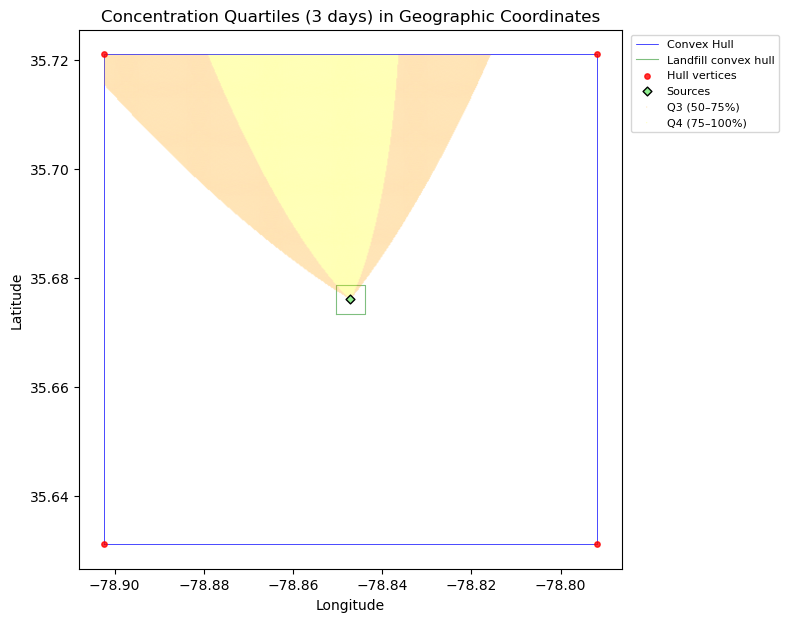

In [105]:
# ------------------------------------------------------------
# 2. Inputs
# ------------------------------------------------------------
synthetic_list = [synthetic_df_0]
titles = ["Day 0", "Day 1", "Day 2"]

# ------------------------------------------------------------
# 3. Convert static geometry once (lat/lon)
# ------------------------------------------------------------
# Sources
src_lat, src_lon = xy_to_latlon(sources[:, 0], sources[:, 1], centroid)

# Hull vertices (grid hull)
hv_lat, hv_lon = xy_to_latlon(hull_vertices[:, 0], hull_vertices[:, 1], centroid)
closed_hv = np.vstack([hull_vertices, hull_vertices[0]])
closed_lat, closed_lon = xy_to_latlon(closed_hv[:, 0], closed_hv[:, 1], centroid)

# Google Earth convex hull (already lat/lon)
ge_hull_lat = landfill_convex_hull_latlon[:, 0]
ge_hull_lon = landfill_convex_hull_latlon[:, 1]
ge_closed_lat = np.r_[ge_hull_lat, ge_hull_lat[0]]
ge_closed_lon = np.r_[ge_hull_lon, ge_hull_lon[0]]

# ------------------------------------------------------------
# 4. GLOBAL quartiles across all days (non-zero only)
# ------------------------------------------------------------
all_c = np.concatenate([
    df["concentration(ngm3)"].to_numpy()[df["concentration(ngm3)"].to_numpy() > 0]
    for df in synthetic_list
])

q1, q2, q3 = np.percentile(all_c, [25, 50, 75])

# ------------------------------------------------------------
# 5. Plot all plumes on ONE map (lat/lon)
# ------------------------------------------------------------
plt.figure(figsize=(7, 7))

# Base polygons
plt.plot(closed_lon, closed_lat, color="blue", lw=0.5, label="Convex Hull")
plt.plot(ge_closed_lon, ge_closed_lat, color="green", lw=0.8, alpha=0.5,
         zorder=1, label="Landfill convex hull")

# Hull vertices + sources
plt.scatter(hv_lon, hv_lat, color="red", s=15, alpha=0.8, zorder=5, label="Hull vertices")
plt.scatter(src_lon, src_lat, c="lightgreen", s=20, marker="D",
            edgecolor="black", zorder=10, label="Sources")

# Plumes (3 days) – same quartile rules, plotted together
s = 1
alpha = 0.2  # slightly lower to reduce overplotting

first = True
for df, title in zip(synthetic_list, titles):
    x = df["x(m)"].to_numpy()
    y = df["y(m)"].to_numpy()
    c = df["concentration(ngm3)"].to_numpy()

    m = c > 0
    if m.sum() == 0:
        continue

    x_nz, y_nz, c_nz = x[m], y[m], c[m]
    lat_nz, lon_nz = xy_to_latlon(x_nz, y_nz, centroid)

    m_q1 = (c_nz <= q1)
    m_q2 = (c_nz > q1) & (c_nz <= q2)
    m_q3 = (c_nz > q2) & (c_nz <= q3)
    m_q4 = (c_nz > q3)

    # labels only once (avoid legend duplication)
    l1 = "Q1 (0–25%)" if first else None
    l2 = "Q2 (25–50%)" if first else None
    l3 = "Q3 (50–75%)" if first else None
    l4 = "Q4 (75–100%)" if first else None

    # plt.scatter(lon_nz[m_q1], lat_nz[m_q1], c="blue",   alpha=alpha, s=s,
    #             linewidths=0, edgecolors="none", zorder=5, label=l1)
    # plt.scatter(lon_nz[m_q2], lat_nz[m_q2], c="red",    alpha=alpha, s=s,
    #             linewidths=0, edgecolors="none", zorder=4, label=l2)
    plt.scatter(lon_nz[m_q3], lat_nz[m_q3], c="orange", alpha=alpha, s=s,
                linewidths=0, edgecolors="none", zorder=3, label=l3)
    plt.scatter(lon_nz[m_q4], lat_nz[m_q4], c="yellow", alpha=alpha, s=s,
                linewidths=0, edgecolors="none", zorder=2, label=l4)

    first = False

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Concentration Quartiles (3 days) in Geographic Coordinates")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.0), fontsize=8)
plt.show()

In [106]:
# ------------------------------------------------------------
# Landmarks LF 26
# ------------------------------------------------------------
shopping = np.array([35.66666982444289, -78.84621817057246])
vet_hostipal = np.array([35.66460787088358, -78.84825655734113])
target = np.array([35.6615716429336, -78.85204814633124])
hardware_store = np.array([35.66018861561622, -78.83721401892609])
pharmacy = np.array([35.65610271518265, -78.83520942949808])
restaurant = np.array([35.659085489863074, -78.86747163110155])
hospital = np.array([35.638964173746885, -78.86356761612264])
school1 = np.array([35.6593501476475, -78.83615919965423])
school2 = np.array([35.677851718685694, -78.83425118888651])
school3 = np.array([35.675537057310905, -78.83281063266132])
school4 = np.array([35.66233876540289, -78.85705059177832])
school5 = np.array([35.66290823855504, -78.86562909281928])
donations = np.array([35.68310392859226, -78.8451576822475])
houses_1 = np.array([35.6937484592186, -78.8294445074716])   
houses_2 = np.array([35.6937484592186, -78.8294445074716])
houses_3 = np.array([35.688411920214385, -78.82777688117082])
houses_4 = np.array([35.688411920214385, -78.82777688117082])
houses_5 = np.array([35.688411920214385, -78.82777688117082])
houses_6 = np.array([35.66511140288021, -78.83029510658524])
houses_7 = np.array([35.66511140288021, -78.83029510658524])
houses_8 = np.array([35.66511140288021, -78.83029510658524])
houses_9 = np.array([35.66511140288021, -78.83029510658524])
houses_10 = np.array([35.649097907522425, -78.88079168481121])
houses_11 = np.array([35.638964173746885, -78.86356761612264])
houses_12 = np.array([35.66493111972084, -78.82715958676552])
houses_13 = np.array([35.66493111972084, -78.82715958676552])
houses_14 = np.array([35.71459647025003, -78.86661812186522])
houses_15 = np.array([35.71459647025003, -78.86661812186522])
houses_16 = np.array([35.71459647025003, -78.86661812186522])
houses_17 = np.array([35.71459647025003, -78.86661812186522])
houses_18 = np.array([35.71459647025003, -78.86661812186522])
houses_19 = np.array([35.66889848479701, -78.81117465301091])
houses_20 = np.array([35.66889848479701, -78.81117465301091])
houses_21 = np.array([35.65095342127041, -78.80497867169798])
houses_22 = np.array([35.65095342127041, -78.80497867169798])
houses_23 = np.array([35.638489045714984, -78.86263932196437])
houses_24 = np.array([35.638489045714984, -78.86263932196437])
houses_25 = np.array([35.638489045714984, -78.86263932196437])
houses_26 = np.array([35.638489045714984, -78.86263932196437])
houses_27 = np.array([35.638489045714984, -78.86263932196437])
houses_28 = np.array([35.638489045714984, -78.86263932196437])
houses_29 = np.array([35.713727598943386, -78.81206902235014])
houses_30 = np.array([35.713727598943386, -78.81206902235014])
houses_31 = np.array([35.67816168686575, -78.86659295081549 ])
houses_32 = np.array([35.667902956398024, -78.87497528484467])
church = np.array([35.66108023711361, -78.89685115770772])

landmarks = {
    "Shopping center":   shopping,
    "Vet hospital":      vet_hostipal,
    "Target":            target,
    "Hardware store":    hardware_store,
    "Pharmacy":          pharmacy,
    "Restaurant":        restaurant,
    "Hospital":          hospital,
    "School 1":          school1,
    "School 2":          school2,
    "School 3":          school3,
    "School 4":          school4,
    "School 5":          school5,
    "Donations":         donations,
    "Houses 1":          houses_1,
    "Houses 2":          houses_2,
    "Houses 3":          houses_3,
    "Houses 4":          houses_4,
    "Houses 5":          houses_5,
    "Houses 6":          houses_6,
    "Houses 7":          houses_7,
    "Houses 8":          houses_8,
    "Houses 9":          houses_9,
    "Houses 10":         houses_10,
    "Houses 11":         houses_11,
    "Houses 12":         houses_12,
    "Houses 13":         houses_13,
    "Houses 14":         houses_14,
    "Houses 15":         houses_15,
    "Houses 16":         houses_16,
    "Houses 17":         houses_17,
    "Houses 18":         houses_18,
    "Houses 19":         houses_19,
    "Houses 20":         houses_20,
    "Houses 21":         houses_21,
    "Houses 22":         houses_22,
    "Houses 23":         houses_23,
    "Houses 24":         houses_24,
    "Houses 25":         houses_25,
    "Houses 26":         houses_26,
    "Houses 27":         houses_27,
    "Houses 28":         houses_28,
    "Houses 29":         houses_29,
    "Houses 30":         houses_30,
    "Houses 31":         houses_31,
    "Houses 32":         houses_32,
    "Church":            church

}

  Landfill        Date  Wind_Direction_deg  Distance_km  \
0   LFS_PS  2021-07-01               170.0            1   
1   LFS_PS  2021-07-01               170.0            3   
2   LFS_PS  2021-07-01               170.0            6   

   Mean_Concentration_ngm3  Std_Concentration_ngm3  N_points  
0                 0.012204                0.018478      1305  
1                 0.000533                0.001126      1471  
2                 0.000003                0.000008      1521  
  Landfill  Distance_km  Mean_Concentration_ngm3  Std_Concentration_ngm3  \
0   LFS_PS            1                 0.012204                0.018478   
1   LFS_PS            3                 0.000533                0.001126   
2   LFS_PS            6                 0.000003                0.000008   

   N_days  Total_points  
0       1          1305  
1       1          1471  
2       1          1521  


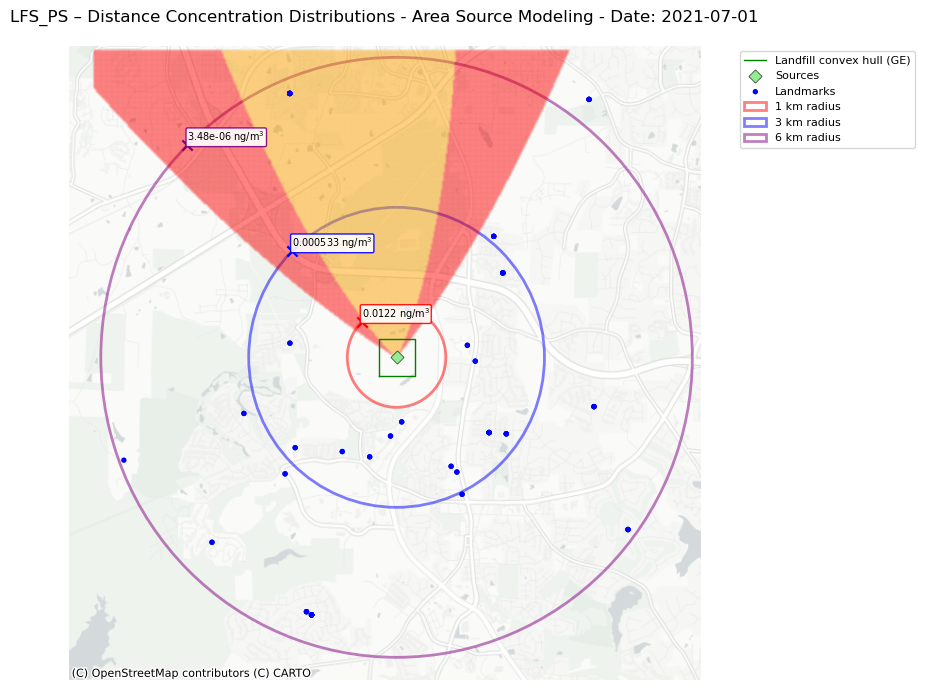

In [107]:
# ------------------------------------------------------------
#   PLOT A: 
# ------------------------------------------------------------

from matplotlib.patches import Circle
import contextily as ctx
from pyproj import Transformer

# ------------------------------------------------------------
# 0. Helpers
# ------------------------------------------------------------
def xy_to_latlon(x, y, centroid, x0=5_000, y0=5_000):
    lat0, lon0 = centroid
    meters_per_deg_lat = 111_320
    meters_per_deg_lon = 111_320 * np.cos(np.deg2rad(lat0))
    dx = x - x0
    dy = y - y0
    lat = lat0 + dy / meters_per_deg_lat
    lon = lon0 + dx / meters_per_deg_lon
    return lat, lon

to_3857 = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

def latlon_to_3857(lat, lon):
    x, y = to_3857.transform(np.asarray(lon), np.asarray(lat))
    return x, y

# ------------------------------------------------------------
# 1. Geometry
# ------------------------------------------------------------
# --- Receptor grid convex hull (BLUE) ---
grid_lat, grid_lon = xy_to_latlon(
    closed_hv[:, 0], closed_hv[:, 1], centroid
)
grid_x, grid_y = latlon_to_3857(grid_lat, grid_lon)

# --- Google Earth landfill hull ---
ge_lat = landfill_convex_hull_latlon[:, 0]
ge_lon = landfill_convex_hull_latlon[:, 1]
ge_lat_c = np.r_[ge_lat, ge_lat[0]]
ge_lon_c = np.r_[ge_lon, ge_lon[0]]
ge_x, ge_y = latlon_to_3857(ge_lat, ge_lon)
ge_xc, ge_yc = latlon_to_3857(ge_lat_c, ge_lon_c)

# --- Hull vertices (red) ---
hv_lat, hv_lon = xy_to_latlon(
    hull_vertices[:, 0], hull_vertices[:, 1], centroid
)
hv_x, hv_y = latlon_to_3857(hv_lat, hv_lon)

# --- Sources ---
src_lat, src_lon = xy_to_latlon(
    sources[:, 0], sources[:, 1], centroid
)
src_x, src_y = latlon_to_3857(src_lat, src_lon)

# ------------------------------------------------------------
# 2. GLOBAL quartiles across all sets
# ------------------------------------------------------------
synthetic_list = [synthetic_df_0]  #, synthetic_df_1, synthetic_df_2]

all_c = np.concatenate([
    df["concentration(ngm3)"].to_numpy()[df["concentration(ngm3)"].to_numpy() > 0]
    for df in synthetic_list
])

q1, q2, q3 = np.percentile(all_c, [25, 50, 75])

# ------------------------------------------------------------
# 3. Collect quartile points ONCE (artifact-free)
# ------------------------------------------------------------
quartile_points = {i: {"lat": [], "lon": []} for i in range(4)}

for df in synthetic_list:
    x = df["x(m)"].to_numpy()
    y = df["y(m)"].to_numpy()
    c = df["concentration(ngm3)"].to_numpy()

    m = c > 0
    if m.sum() == 0:
        continue

    x, y, c = x[m], y[m], c[m]
    lat, lon = xy_to_latlon(x, y, centroid)

    masks = [
        c <= q1,
        (c > q1) & (c <= q2),
        (c > q2) & (c <= q3),
        c > q3,
    ]

    for i in range(4):
        if masks[i].sum() > 0:
            quartile_points[i]["lat"].append(lat[masks[i]])
            quartile_points[i]["lon"].append(lon[masks[i]])

quartile_points_3857 = {}
for i in range(4):
    if quartile_points[i]["lat"]:
        lat_i = np.concatenate(quartile_points[i]["lat"])
        lon_i = np.concatenate(quartile_points[i]["lon"])
        quartile_points_3857[i] = latlon_to_3857(lat_i, lon_i)

# ------------------------------------------------------------
# 4. Plot
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(9, 7))

# --- EXTENT from receptor grid hull (this is the key fix) ---
pad = 800  # meters
xmin, xmax = grid_x.min() - pad, grid_x.max() + pad
ymin, ymax = grid_y.min() - pad, grid_y.max() + pad
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# --- Basemap ---
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.PositronNoLabels,
    crs="EPSG:3857"
)

# --- Quartiles ---
colors_q = ["blue", "purple", "red", "orange"]
labels_q = ["Q1 (0–25%)", "Q2 (25–50%)", "Q3 (50–75%)", "Q4 (75–100%)"]

for i in range(2, 4):
    if i not in quartile_points_3857:
        continue
    X, Y = quartile_points_3857[i]
    ax.scatter(
        X, Y,
        c=colors_q[i],
        s=6,
        alpha=0.1,
        linewidths=0,
        edgecolors="none",
        rasterized=True,
        zorder=7,
        #label=labels_q[i]
    )

# --- Landfill hull (GE) ---
ax.plot(
    ge_xc, ge_yc,
    color="green", lw=1,
    zorder=10,
    label="Landfill convex hull (GE)"
)

# # --- Hull vertices ---
# ax.scatter(
#     hv_x, hv_y,
#     color="red", s=20,
#     zorder=4,
#     label="Hull vertices"
# )

# --- Sources ---
ax.scatter(
    src_x, src_y,
    c="lightgreen",
    s=45,
    marker="D",
    edgecolors="black",
    linewidths=0.4,
    zorder=9,
    label="Sources"
)

# --- Receptor grid convex hull (BLUE) ---
# ax.plot(
#     grid_x, grid_y,
#     color="blue", lw=1,
#     zorder=3,
#     label="Receptor grid convex hull"
# )

# Reference source point in EPSG:3857 (mean of sources)
src_ref_x = float(np.mean(src_x))
src_ref_y = float(np.mean(src_y))

offset = 100.0  # meters (label pushed outward from the tip

# --------------------------------------------------------
# Date labels for each synthetic dataset
# --------------------------------------------------------
date_labels = weather_df["Date"].iloc[:len(synthetic_list)].dt.strftime("%Y-%m-%d").tolist()

for df, dlab in zip(synthetic_list, date_labels):
    c = df["concentration(ngm3)"].to_numpy()
    m = c > 0
    if m.sum() == 0:
        continue

    x = df["x(m)"].to_numpy()[m]
    y = df["y(m)"].to_numpy()[m]

    lat, lon = xy_to_latlon(x, y, centroid)
    X, Y = latlon_to_3857(lat, lon)

    # --------------------------------------------------------
    # Tip = farthest point from the source (never the centroid)
    # --------------------------------------------------------
    dx = X - src_ref_x
    dy = Y - src_ref_y
    r2 = dx*dx + dy*dy

    k = int(np.argmax(r2))
    x_tip = float(X[k])
    y_tip = float(Y[k])

    # Direction from source to tip (unit vector)
    norm = float(np.hypot(dx[k], dy[k]))
    if norm == 0.0:
        continue  # extremely unlikely; avoids centroid placement

    ux = float(dx[k] / norm)
    uy = float(dy[k] / norm)

    # Push label outward from the tip (same direction)
    x_center = x_tip + offset * ux
    y_center = y_tip + offset * uy

    # ax.text(
    #     -8774000, 4260000,
    #     dlab,
    #     fontsize=8,
    #     ha="center", va="center",
    #     bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="black", alpha=1),
    #     zorder=20
    #)

# ------------------------------------------------------------
# Landmarks (given in lat/lon EPSG:4326) → plot in EPSG:3857
# ------------------------------------------------------------
lm_lat = np.array([v[0] for v in landmarks.values()], dtype=float)
lm_lon = np.array([v[1] for v in landmarks.values()], dtype=float)

lm_x, lm_y = latlon_to_3857(lm_lat, lm_lon)

ax.scatter(
    lm_x, lm_y,
    c="blue", s=15, marker="o",
    linewidths=0, edgecolors="none",
    zorder=12
)
ax.scatter(
    lm_x[:-1], lm_y[:-1],
    c="blue", s=15, marker="o",
    linewidths=0, edgecolors="none",
    label="Landmarks",
    zorder=12
)

# ------------------------------------------------------------
# Circles indicating max distances for Q4 and Q1
# ------------------------------------------------------------

ax.add_patch(
    Circle(
        (src_ref_x, src_ref_y),
       # (5000, 5000),
        radius=1000, #max_r_q4,
        fill=False,
        edgecolor="red",
        linewidth=2.0,
        alpha=0.5,
        zorder=4,
        label=rf"1 km radius"
    )
)
ax.add_patch(
    Circle(
        (src_ref_x, src_ref_y),
       # (5000, 5000),
        radius=3000, #max_r_q4,
        fill=False,
        edgecolor="blue",
        linewidth=2.0,
        alpha=0.5,
        zorder=4,
        label=rf"3 km radius"
    )
)
ax.add_patch(
    Circle(
        (src_ref_x, src_ref_y),
       # (5000, 5000),
        radius=6000, #max_r_q4,
        fill=False,
        edgecolor="purple",
        linewidth=2.0,
        alpha=0.5,
        zorder=4,
        label=rf"6 km radius"
    )
)


# ------------------------------------------------------------
# 4.b Cross-section statistics at 1/3/6 km (mean + std across transverse plume)
# ------------------------------------------------------------
targets_m = np.array([1000.0, 3000.0, 6000.0])   # meters
crosswind_tol = 1500.0                           # meters (width of cross-section)
along_tol = 150.0                                # meters (thickness around the target distance)
                       # set as needed

rows = []

for df, dlab in zip(synthetic_list, date_labels):
    c_full = df["concentration(ngm3)"].to_numpy()
    m = c_full > 0
    if m.sum() == 0:
        continue

    x_m = df["x(m)"].to_numpy()[m]
    y_m = df["y(m)"].to_numpy()[m]
    c = c_full[m]

    lat, lon = xy_to_latlon(x_m, y_m, centroid)
    X, Y = latlon_to_3857(lat, lon)

    # plume direction = farthest nonzero point from source reference
    dx = X - src_ref_x
    dy = Y - src_ref_y
    r2 = dx * dx + dy * dy
    k = int(np.argmax(r2))

    norm = float(np.hypot(dx[k], dy[k]))
    if norm == 0.0:
        continue

    ux = float(dx[k] / norm)
    uy = float(dy[k] / norm)

    # coordinates relative to source
    rx = X - src_ref_x
    ry = Y - src_ref_y

    # along-wind coordinate and crosswind distance
    t = rx * ux + ry * uy
    perp = np.abs(rx * (-uy) + ry * (ux))

    # optional day metadata
    wind_dir = np.nan
    if "Wind_Direction" in weather_df.columns:
        w = weather_df.loc[weather_df["Date"] == pd.to_datetime(dlab), "Wind_Direction"]
        wind_dir = float(w.iloc[0]) if len(w) else np.nan

    for target in targets_m:
        km = int(target / 1000)

        # cross-section selection (downwind, near target distance, within crosswind band)
        sel = (t > 0) & (np.abs(t - target) <= along_tol) & (perp <= crosswind_tol)
        if sel.sum() == 0:
            continue

        c_sec = c[sel]
        c_sec = c_sec[c_sec > 0]  # ensure strictly nonzero

        if c_sec.size == 0:
            continue

        rows.append({
            "Landfill": landfill,
            "Date": dlab,
            "Wind_Direction_deg": wind_dir,
            "Distance_km": km,
            "Mean_Concentration_ngm3": float(np.mean(c_sec)),
            "Std_Concentration_ngm3": float(np.std(c_sec, ddof=1)) if c_sec.size > 1 else float(np.std(c_sec)),
            "N_points": int(c_sec.size),
        })

# Day-level, long (one row per day per distance)
plume_xsec_df = pd.DataFrame(rows)

# Aggregated: one row per distance (pooled across all days/points via day-level rows)
plume_stats_df = (
    plume_xsec_df
    .groupby(["Landfill", "Distance_km"], as_index=False)
    .agg(
        Mean_Concentration_ngm3=("Mean_Concentration_ngm3", "mean"),
        Std_Concentration_ngm3=("Std_Concentration_ngm3", "mean"),
        N_days=("Date", "nunique"),
        Total_points=("N_points", "sum"),
    )
)

print(plume_xsec_df)
print(plume_stats_df)


# --- Plot mean concentration labels at 1/3/6 km on the plume centerline ---
box_colors = {1: "red", 3: "blue", 6: "purple"}

# Need a plume direction (ux, uy). Use the last computed one, or compute once beforehand.
# Guard: if ux/uy not defined, stop early.
if "ux" not in locals() or "uy" not in locals():
    raise ValueError("ux/uy not defined. Compute plume direction before labeling points.")

if plume_stats_df.empty:
    print("plume_stats_df is empty: no cross-section stats were computed.")
else:
    for _, r in plume_stats_df.iterrows():
        km = int(r["Distance_km"])
        if km not in box_colors:
            continue

        # centerline point at km distance from source reference (EPSG:3857 meters)
        x_pt = src_ref_x + (km * 1000.0) * ux
        y_pt = src_ref_y + (km * 1000.0) * uy

        ax.scatter(
            x_pt, y_pt,
            s=55,
            marker="x",
            linewidths=1.6,
            color=box_colors[km],
            zorder=15
        )

        ax.text(
            x_pt, y_pt,
            f"{r['Mean_Concentration_ngm3']:.3g} ng/m$^3$",
            fontsize=7,
            ha="left",
            va="bottom",
            bbox=dict(
                boxstyle="round,pad=0.15",
                fc="white",
                ec=box_colors[km],
                alpha=0.9
            ),
            zorder=16
        )


# ------------------------------------------------------------
# 5. Formatting
# ------------------------------------------------------------
ax.set_title(f"{landfill} – Distance Concentration Distributions - Area Source Modeling - Date: {dlab}")
ax.legend(loc="upper left", fontsize=8)
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.0), fontsize=8)
#plt.xlim(-8_783_380-500, -8_771_069)
plt.xlim(hv_x[0]-500, hv_x[2])
plt.ylim(hv_y[0]-300, hv_y[2]+80)
ax.axis("off")

plt.tight_layout()
#plt.savefig(f"../img/final/{landfill}_Distance_Concentration_Distributions_AreaSource_{dlab}.png", dpi=300)
plt.show()

# ------------------------------------------------------------
#   PLOT A: 
# ------------------------------------------------------------

     Day        Date  Wind_Direction_deg  Conc_at_1km_ngm3  Point_1km_x3857  \
0  Day 0  2021-07-01               170.0           0.05233    -8.777471e+06   

   Point_1km_y3857  Conc_at_3km_ngm3  Point_3km_x3857  Point_3km_y3857  \
0     4.257349e+06          0.006401    -8.777840e+06     4.259787e+06   

   Conc_at_6km_ngm3  Point_6km_x3857  Point_6km_y3857  
0          0.000005    -8.781361e+06     4.262275e+06  
  Landfill        Date                   Type  Wind_Direction_deg  \
0   LFS_PS  2021-07-01  Point_Source_Modeling               170.0   
1   LFS_PS  2021-07-01  Point_Source_Modeling               170.0   
2   LFS_PS  2021-07-01  Point_Source_Modeling               170.0   

   Distance_km  Mean_Concentration_ngm3  Std_Concentration_ngm3  N_points  
0            1                 0.052330                     0.0       384  
1            3                 0.006401                     0.0      1066  
2            6                 0.000005                     0.0       570  

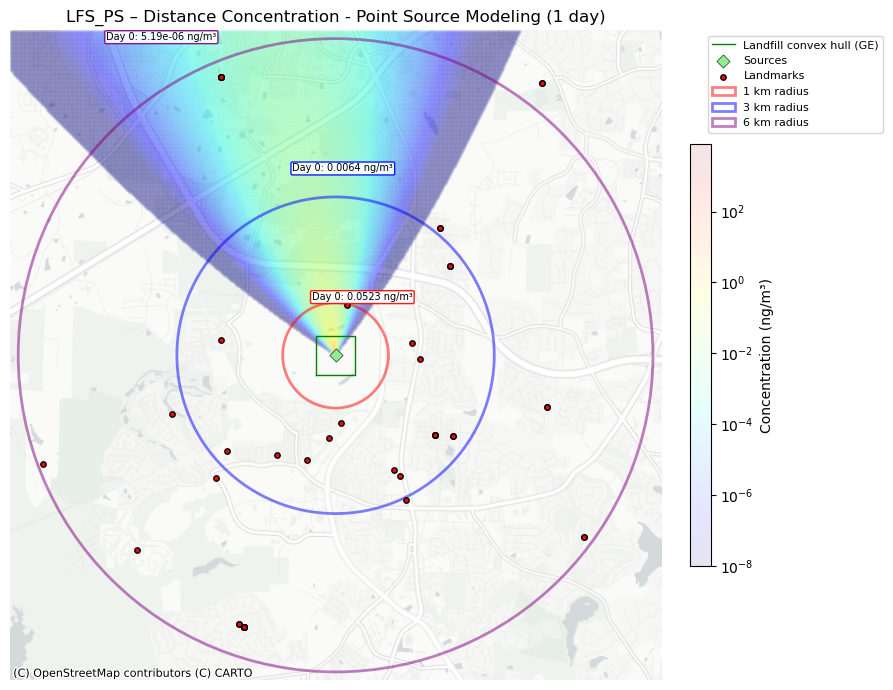

In [ ]:
# ------------------------------------------------------------
#   PLOT B: 
# ------------------------------------------------------------
# This implementation reports concentrations at 1, 3, and 6 km using a radial ring–maximum approach.
# For each day, receptor distances are computed in the original model coordinate system (meters),
# using the same source reference as the dispersion model. For each target distance (1000, 3000,
# 6000 m), receptors lying within a thin annulus [R, R + ΔR] (with ΔR = 50 m) are selected, and the
# maximum concentration within that annulus is reported as the representative value. This choice
# approximates the plume centerline concentration at that distance while remaining robust to plume
# direction ambiguity, numerical noise at large distances, and multi-day variability. The reported
# value is therefore not an average over a cross-section, but a physically meaningful upper bound
# along the plume envelope at the specified radius.

from matplotlib.patches import Circle
from matplotlib.colors import LogNorm
import contextily as ctx
from pyproj import Transformer

# ------------------------------------------------------------
# 0. Helpers
# ------------------------------------------------------------
def xy_to_latlon(x, y, centroid, x0=5_000, y0=5_000):
    lat0, lon0 = centroid
    meters_per_deg_lat = 111_320
    meters_per_deg_lon = 111_320 * np.cos(np.deg2rad(lat0))
    dx = x - x0
    dy = y - y0
    lat = lat0 + dy / meters_per_deg_lat
    lon = lon0 + dx / meters_per_deg_lon
    return lat, lon

to_3857 = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

def latlon_to_3857(lat, lon):
    x, y = to_3857.transform(np.asarray(lon), np.asarray(lat))
    return x, y

# ------------------------------------------------------------
# 1. Geometry (static)
# ------------------------------------------------------------
grid_lat, grid_lon = xy_to_latlon(closed_hv[:, 0], closed_hv[:, 1], centroid)
grid_x, grid_y = latlon_to_3857(grid_lat, grid_lon)

# --- Google Earth landfill hull ---
ge_lat = landfill_convex_hull_latlon[:, 0]
ge_lon = landfill_convex_hull_latlon[:, 1]
ge_lat_c = np.r_[ge_lat, ge_lat[0]]
ge_lon_c = np.r_[ge_lon, ge_lon[0]]
ge_x, ge_y = latlon_to_3857(ge_lat, ge_lon)
ge_xc, ge_yc = latlon_to_3857(ge_lat_c, ge_lon_c)

hv_lat, hv_lon = xy_to_latlon(hull_vertices[:, 0], hull_vertices[:, 1], centroid)
hv_x, hv_y = latlon_to_3857(hv_lat, hv_lon)

src_lat, src_lon = xy_to_latlon(sources[:, 0], sources[:, 1], centroid)
src_x, src_y = latlon_to_3857(src_lat, src_lon)

# Plot center (EPSG:3857)
src_ref_x = float(np.mean(src_x))
src_ref_y = float(np.mean(src_y))

# Model-meter center (USED FOR DISTANCES)
src_ref_x_m = float(np.mean(sources[:, 0]))
src_ref_y_m = float(np.mean(sources[:, 1]))

# ------------------------------------------------------------
# 2. Use THREE days
# ------------------------------------------------------------
synthetic_list = [synthetic_df_0] #, synthetic_df_1, synthetic_df_2]
titles = ["Day 0", "Day 1", "Day 2"]

date_labels = (
    weather_df["Date"]
    .iloc[:len(synthetic_list)]
    .dt.strftime("%Y-%m-%d")
    .tolist()
)

# ------------------------------------------------------------
# 3. GLOBAL quartiles across all days (non-zero only)
# ------------------------------------------------------------
all_c = np.concatenate([
    df["concentration(ngm3)"].to_numpy()[df["concentration(ngm3)"].to_numpy() > 0]
    for df in synthetic_list
])
q1, q2, q3 = np.percentile(all_c, [25, 50, 75])

# ------------------------------------------------------------
# 4. Collect quartile points ONCE (all days)
# ------------------------------------------------------------
quartile_points = {i: {"lat": [], "lon": [], "c": []} for i in range(4)}

for df in synthetic_list:
    x = df["x(m)"].to_numpy()
    y = df["y(m)"].to_numpy()
    c = df["concentration(ngm3)"].to_numpy()

    m = c > 0
    if m.sum() == 0:
        continue

    x, y, c = x[m], y[m], c[m]
    lat, lon = xy_to_latlon(x, y, centroid)

    masks = [
        c <= q1,
        (c > q1) & (c <= q2),
        (c > q2) & (c <= q3),
        c > q3,
    ]

    for i in range(4):
        if masks[i].sum() > 0:
            quartile_points[i]["lat"].append(lat[masks[i]])
            quartile_points[i]["lon"].append(lon[masks[i]])
            quartile_points[i]["c"].append(c[masks[i]])

quartile_points_3857 = {}
for i in range(4):
    if quartile_points[i]["lat"]:
        lat_i = np.concatenate(quartile_points[i]["lat"])
        lon_i = np.concatenate(quartile_points[i]["lon"])
        c_i = np.concatenate(quartile_points[i]["c"])
        X_i, Y_i = latlon_to_3857(lat_i, lon_i)
        quartile_points_3857[i] = (X_i, Y_i, c_i)

# ------------------------------------------------------------
# 5. Plot (UNCHANGED)
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(9, 7))

pad = 800
xmin, xmax = grid_x.min() - pad, grid_x.max() + pad
ymin, ymax = grid_y.min() - pad, grid_y.max() + pad
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.PositronNoLabels,
    crs="EPSG:3857"
)

Xs, Ys, Cs = [], [], []
for i in range(2, 4):  # Q3 and Q4
    if i not in quartile_points_3857:
        continue
    X_i, Y_i, C_i = quartile_points_3857[i]
    Xs.append(X_i); Ys.append(Y_i); Cs.append(C_i)

vmin = 1e-8
vmax = 8000
norm = LogNorm(vmin=vmin, vmax=vmax)

if len(Cs) > 0:
    X = np.concatenate(Xs)
    Y = np.concatenate(Ys)
    C = np.concatenate(Cs)
    sc = ax.scatter(
        X, Y,
        c=C,
        cmap="jet",
        norm=norm,
        s=6,
        alpha=0.1,
        linewidths=0,
        edgecolors="none",
        zorder=2,
    )

ax.plot(ge_xc, ge_yc, color="green", lw=1, zorder=10, label="Landfill convex hull (GE)")

ax.scatter(
    src_x, src_y,
    c="lightgreen", s=45, marker="D",
    edgecolors="black", linewidths=0.4,
    zorder=9, label="Sources"
)

lm_lat = np.array([v[0] for v in landmarks.values()], dtype=float)
lm_lon = np.array([v[1] for v in landmarks.values()], dtype=float)
lm_x, lm_y = latlon_to_3857(lm_lat, lm_lon)

ax.scatter(lm_x[:-1], lm_y[:-1], c="red", s=15, marker="o",
           linewidths=1, edgecolors="black", label="Landmarks", zorder=12)
ax.scatter(lm_x[-1:], lm_y[-1:], c="red", s=15, marker="o",
           linewidths=1, edgecolors="black", zorder=12)

ax.add_patch(Circle((src_ref_x, src_ref_y), radius=1000, fill=False,
                    edgecolor="red", linewidth=2.0, alpha=0.5, zorder=4, label="1 km radius"))
ax.add_patch(Circle((src_ref_x, src_ref_y), radius=3000, fill=False,
                    edgecolor="blue", linewidth=2.0, alpha=0.5, zorder=4, label="3 km radius"))
ax.add_patch(Circle((src_ref_x, src_ref_y), radius=6000, fill=False,
                    edgecolor="purple", linewidth=2.0, alpha=0.5, zorder=4, label="6 km radius"))

# ------------------------------------------------------------
# 6B. Per-day RING MAX at 1/3/6 km (NO pooling)
#     Robust: distances computed in MODEL METERS.
#     Also builds plume_xsec_df (LONG) with the old 6A structure.
# ------------------------------------------------------------
targets_m = np.array([1000.0, 3000.0, 6000.0], dtype=float)
tol_m = 50.0  # ring thickness: [target, target + tol]

results = []
plume_xsec_rows = []

for df, dlab, title in zip(synthetic_list, date_labels, titles):
    c_full = df["concentration(ngm3)"].to_numpy()
    m = c_full > 0
    if m.sum() == 0:
        continue

    x_m = df["x(m)"].to_numpy()[m].astype(float)
    y_m = df["y(m)"].to_numpy()[m].astype(float)
    c = c_full[m].astype(float)

    # radial distance in MODEL METERS from the same model-meter center as sources
    r_m = np.hypot(x_m - src_ref_x_m, y_m - src_ref_y_m)

    wind_dir = np.nan
    if "Wind_Direction" in weather_df.columns:
        w = weather_df.loc[weather_df["Date"] == pd.to_datetime(dlab), "Wind_Direction"]
        wind_dir = float(w.iloc[0]) if len(w) else np.nan

    row = {"Day": title, "Date": dlab, "Wind_Direction_deg": wind_dir}

    for target in targets_m:
        km = int(target / 1000)

        sel = (r_m >= target) & (r_m <= (target + tol_m))
        if sel.sum() == 0:
            row[f"Conc_at_{km}km_ngm3"] = np.nan
            row[f"Point_{km}km_x3857"] = np.nan
            row[f"Point_{km}km_y3857"] = np.nan
            continue

        c_ring = c[sel]
        # take max as the reported value
        idx_local = int(np.argmax(c_ring))
        conc_val = float(c_ring[idx_local])

        # recover the (x_m, y_m) of the max point inside the ring
        x_ring = x_m[sel]
        y_ring = y_m[sel]
        x_pick_m = float(x_ring[idx_local])
        y_pick_m = float(y_ring[idx_local])

        # convert picked point to EPSG:3857 for plotting
        lat_p, lon_p = xy_to_latlon(x_pick_m, y_pick_m, centroid)
        Xp, Yp = latlon_to_3857(lat_p, lon_p)

        row[f"Conc_at_{km}km_ngm3"] = conc_val
        row[f"Point_{km}km_x3857"] = float(Xp)
        row[f"Point_{km}km_y3857"] = float(Yp)

        # long-format row (old 6A structure)
        plume_xsec_rows.append({
            "Landfill": landfill,
            "Date": dlab,
            "Type": "Point_Source_Modeling",
            "Wind_Direction_deg": wind_dir,
            "Distance_km": km,
            "Mean_Concentration_ngm3": conc_val,  # by design: ring max
            "Std_Concentration_ngm3": 0.0,
            "N_points": int(sel.sum()),
        })

    results.append(row)

plume_conc_df = pd.DataFrame(results)
print(plume_conc_df)

plume_xsec_df = pd.DataFrame(plume_xsec_rows)
print(plume_xsec_df)

# ------------------------------------------------------------
# Plot markers/labels: 3 days × (1,3,6)
# ------------------------------------------------------------
box_colors = {1: "red", 3: "blue", 6: "purple"}

for _, r in plume_conc_df.iterrows():
    day_tag = str(r["Day"])
    for km in (1, 3, 6):
        conc_key = f"Conc_at_{km}km_ngm3"
        xk = f"Point_{km}km_x3857"
        yk = f"Point_{km}km_y3857"

        if conc_key not in r or not np.isfinite(r[conc_key]):
            continue

        day_offsets = {"Day 0": (-200.0, -200.0), "Day 1": (200.0, 200.0), "Day 2": (12.0, 12.0)}
        ox, oy = day_offsets.get(day_tag, (0.0, 0.0))

        px = float(r[xk]) + ox
        py = float(r[yk]) + oy

        # ax.scatter(px, py, s=35, marker="x", linewidths=1.2,
        #            color=box_colors[km], zorder=15)

        ax.text(px, py, f"{day_tag}: {float(r[conc_key]):.3g} ng/m³",
                fontsize=7, ha="left", va="bottom",
                bbox=dict(boxstyle="round,pad=0.15", fc="white",
                          ec=box_colors[km], alpha=0.9),
                zorder=31)

# ------------------------------------------------------------
# 7. Formatting (UNCHANGED)
# ------------------------------------------------------------
ax.set_title(f"{landfill} – Distance Concentration - Point Source Modeling (1 day)")
ax.legend(loc="upper left", fontsize=8)
plt.legend(loc="upper right", bbox_to_anchor=(1.35, 1.0), fontsize=8)
plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, shrink=0.65, label="Concentration (ng/m³)")

plt.xlim(hv_x[0], hv_x[2])
plt.ylim(hv_y[0], hv_y[2])
plt.axis("off")
plt.tight_layout()
#plt.savefig(f"../img/final/{landfill}_Distance_Concentration_Point_Source_Modeling_3_Days.png", dpi=300)
plt.show()

# ------------------------------------------------------------
#   PLOT B: 
# ------------------------------------------------------------

          Day        Date  Wind_Direction_deg  Conc_at_500m_ngm3  \
0  2021-07-01  2021-07-01               170.0           0.201503   

   Point_500m_x3857  Point_500m_y3857  Conc_at_1000m_ngm3  Point_1000m_x3857  \
0     -8.777323e+06      4.256759e+06             0.05233      -8.777471e+06   

   Point_1000m_y3857  Conc_at_2000m_ngm3  Point_2000m_x3857  \
0       4.257349e+06            0.013747      -8.777643e+06   

   Point_2000m_y3857  Distancia_c_eq_1_m  
0       4.258581e+06               200.0  
  Landfill        Date                   Type  Wind_Direction_deg  Distance_m  \
0   LFS_PS  2021-07-01  Point_Source_Modeling               170.0       500.0   
1   LFS_PS  2021-07-01  Point_Source_Modeling               170.0      1000.0   
2   LFS_PS  2021-07-01  Point_Source_Modeling               170.0      2000.0   
3   LFS_PS  2021-07-01  Point_Source_Modeling               170.0       200.0   

   Mean_Concentration_ngm3  Std_Concentration_ngm3  N_points  
0                 0.

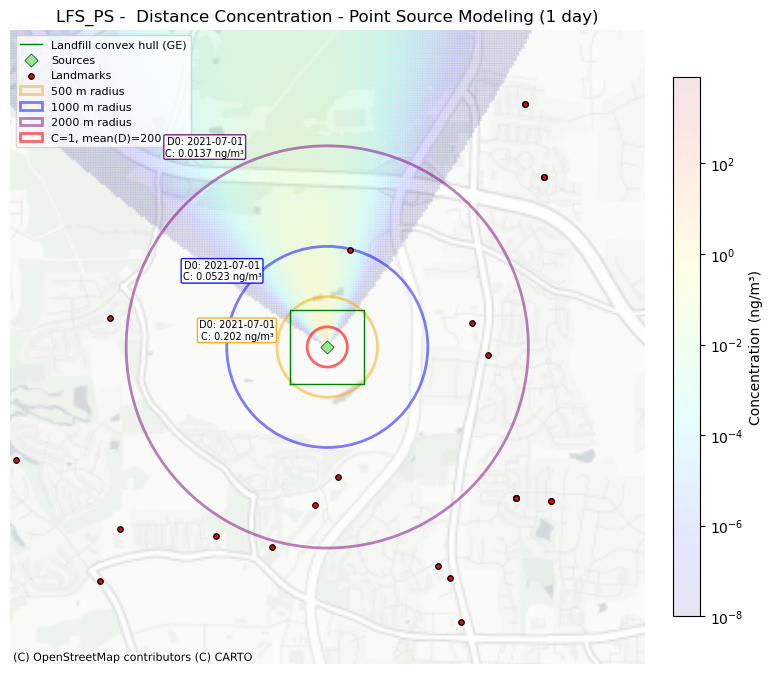

In [110]:
# ------------------------------------------------------------
#   PLOT C:
# ------------------------------------------------------------

from matplotlib.patches import Circle
from matplotlib.colors import LogNorm
import contextily as ctx
from pyproj import Transformer

# ------------------------------------------------------------
# 0. Helpers
# ------------------------------------------------------------
def xy_to_latlon(x, y, centroid, x0=5_000, y0=5_000):
    lat0, lon0 = centroid
    meters_per_deg_lat = 111_320
    meters_per_deg_lon = 111_320 * np.cos(np.deg2rad(lat0))
    dx = x - x0
    dy = y - y0
    lat = lat0 + dy / meters_per_deg_lat
    lon = lon0 + dx / meters_per_deg_lon
    return lat, lon

to_3857 = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

def latlon_to_3857(lat, lon):
    x, y = to_3857.transform(np.asarray(lon), np.asarray(lat))
    return x, y

# ------------------------------------------------------------
# 1. Geometry (static)
# ------------------------------------------------------------
grid_lat, grid_lon = xy_to_latlon(closed_hv[:, 0], closed_hv[:, 1], centroid)
grid_x, grid_y = latlon_to_3857(grid_lat, grid_lon)

ge_lat = landfill_convex_hull_latlon[:, 0]
ge_lon = landfill_convex_hull_latlon[:, 1]
ge_lat_c = np.r_[ge_lat, ge_lat[0]]
ge_lon_c = np.r_[ge_lon, ge_lon[0]]
ge_xc, ge_yc = latlon_to_3857(ge_lat_c, ge_lon_c)

hv_lat, hv_lon = xy_to_latlon(hull_vertices[:, 0], hull_vertices[:, 1], centroid)
hv_x, hv_y = latlon_to_3857(hv_lat, hv_lon)

src_lat, src_lon = xy_to_latlon(sources[:, 0], sources[:, 1], centroid)
src_x, src_y = latlon_to_3857(src_lat, src_lon)

# Plot center (EPSG:3857)
src_ref_x = float(np.mean(src_x))
src_ref_y = float(np.mean(src_y))

# Model-meter center (USED FOR DISTANCES)
src_ref_x_m = float(np.mean(sources[:, 0]))
src_ref_y_m = float(np.mean(sources[:, 1]))

# ------------------------------------------------------------
# 2. Use THREE days
# ------------------------------------------------------------
synthetic_list = [synthetic_df_0]

date_labels = (
    weather_df["Date"]
    .iloc[:len(synthetic_list)]
    .dt.strftime("%Y-%m-%d")
    .tolist()
)

titles = date_labels[:]  # use real dates instead of Day 0/1/2

# ------------------------------------------------------------
# 3. GLOBAL quartiles across all days (non-zero only)
# ------------------------------------------------------------
all_c = np.concatenate([
    df["concentration(ngm3)"].to_numpy()[df["concentration(ngm3)"].to_numpy() > 0]
    for df in synthetic_list
])
q1, q2, q3 = np.percentile(all_c, [25, 50, 75])

# ------------------------------------------------------------
# 4. Collect quartile points ONCE (all days)
# ------------------------------------------------------------
quartile_points = {i: {"lat": [], "lon": [], "c": []} for i in range(4)}

for df in synthetic_list:
    x = df["x(m)"].to_numpy()
    y = df["y(m)"].to_numpy()
    c = df["concentration(ngm3)"].to_numpy()

    m = c > 0
    if m.sum() == 0:
        continue

    x, y, c = x[m], y[m], c[m]
    lat, lon = xy_to_latlon(x, y, centroid)

    masks = [
        c <= q1,
        (c > q1) & (c <= q2),
        (c > q2) & (c <= q3),
        c > q3,
    ]

    for i in range(4):
        if masks[i].sum() > 0:
            quartile_points[i]["lat"].append(lat[masks[i]])
            quartile_points[i]["lon"].append(lon[masks[i]])
            quartile_points[i]["c"].append(c[masks[i]])

quartile_points_3857 = {}
for i in range(4):
    if quartile_points[i]["lat"]:
        lat_i = np.concatenate(quartile_points[i]["lat"])
        lon_i = np.concatenate(quartile_points[i]["lon"])
        c_i = np.concatenate(quartile_points[i]["c"])
        X_i, Y_i = latlon_to_3857(lat_i, lon_i)
        quartile_points_3857[i] = (X_i, Y_i, c_i)

# ------------------------------------------------------------
# 5. Plot (UNCHANGED)
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 7))

pad = 800
xmin, xmax = grid_x.min() - pad, grid_x.max() + pad
ymin, ymax = grid_y.min() - pad, grid_y.max() + pad
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.PositronNoLabels,
    crs="EPSG:3857"
)

Xs, Ys, Cs = [], [], []
for i in range(2, 4):  # Q3 and Q4
    if i not in quartile_points_3857:
        continue
    X_i, Y_i, C_i = quartile_points_3857[i]
    Xs.append(X_i); Ys.append(Y_i); Cs.append(C_i)

vmin = 1e-8
vmax = 8000
norm = LogNorm(vmin=vmin, vmax=vmax)

if len(Cs) > 0:
    X = np.concatenate(Xs)
    Y = np.concatenate(Ys)
    C = np.concatenate(Cs)
    ax.scatter(
        X, Y,
        c=C,
        cmap="jet",
        norm=norm,
        s=6,  # size of points SSS
        alpha=0.1,
        linewidths=0,
        edgecolors="none",
        zorder=2,
    )

ax.plot(ge_xc, ge_yc, color="green", lw=1, zorder=10, label="Landfill convex hull (GE)")

ax.scatter(
    src_x, src_y,
    c="lightgreen", s=45, marker="D",
    edgecolors="black", linewidths=0.4,
    zorder=9, label="Sources"
)

lm_lat = np.array([v[0] for v in landmarks.values()], dtype=float)
lm_lon = np.array([v[1] for v in landmarks.values()], dtype=float)
lm_x, lm_y = latlon_to_3857(lm_lat, lm_lon)

ax.scatter(lm_x[:-1], lm_y[:-1], c="red", s=15, marker="o",
           linewidths=1, edgecolors="black", label="Landmarks", zorder=12)
ax.scatter(lm_x[-1:], lm_y[-1:], c="red", s=15, marker="o",
           linewidths=1, edgecolors="black", zorder=12)

# ------------------------------------------------------------
# Circles at 500m, 1000m, 2000m (UPDATED)
# ------------------------------------------------------------
ax.add_patch(Circle((src_ref_x, src_ref_y), radius=500,  fill=False,
                    edgecolor="orange", linewidth=2.0, alpha=0.5, zorder=4, label="500 m radius"))
ax.add_patch(Circle((src_ref_x, src_ref_y), radius=1000, fill=False,
                    edgecolor="blue",   linewidth=2.0, alpha=0.5, zorder=4, label="1000 m radius"))
ax.add_patch(Circle((src_ref_x, src_ref_y), radius=2000, fill=False,
                    edgecolor="purple", linewidth=2.0, alpha=0.5, zorder=4, label="2000 m radius"))

# ------------------------------------------------------------
# 6B. Per-day RING MAX at 500/1000/2000 m + 4th distance where max ~= 1 (UPDATED)
# ------------------------------------------------------------
targets_m = np.array([500.0, 1000.0, 2000.0], dtype=float)
tol_m = 50.0  # ring thickness: [target, target + tol]

results = []
plume_xsec_rows = []

for df, dlab, title in zip(synthetic_list, date_labels, titles):
    c_full = df["concentration(ngm3)"].to_numpy()
    m = c_full > 0
    if m.sum() == 0:
        continue

    x_m = df["x(m)"].to_numpy()[m].astype(float)
    y_m = df["y(m)"].to_numpy()[m].astype(float)
    c = c_full[m].astype(float)

    # radial distance in MODEL METERS from the same model-meter center as sources
    r_m = np.hypot(x_m - src_ref_x_m, y_m - src_ref_y_m)

    wind_dir = np.nan
    if "Wind_Direction" in weather_df.columns:
        w = weather_df.loc[weather_df["Date"] == pd.to_datetime(dlab), "Wind_Direction"]
        wind_dir = float(w.iloc[0]) if len(w) else np.nan

    row = {"Day": title, "Date": dlab, "Wind_Direction_deg": wind_dir}

    # --- compute ring max at 500/1000/2000 ---
    for target in targets_m:
        dist_m = int(target)

        sel = (r_m >= target) & (r_m <= (target + tol_m))
        if sel.sum() == 0:
            row[f"Conc_at_{dist_m}m_ngm3"] = np.nan
            row[f"Point_{dist_m}m_x3857"] = np.nan
            row[f"Point_{dist_m}m_y3857"] = np.nan
            continue

        c_ring = c[sel]
        idx_local = int(np.argmax(c_ring))
        conc_val = float(c_ring[idx_local])

        x_ring = x_m[sel]
        y_ring = y_m[sel]
        x_pick_m = float(x_ring[idx_local])
        y_pick_m = float(y_ring[idx_local])

        lat_p, lon_p = xy_to_latlon(x_pick_m, y_pick_m, centroid)
        Xp, Yp = latlon_to_3857(lat_p, lon_p)

        row[f"Conc_at_{dist_m}m_ngm3"] = conc_val
        row[f"Point_{dist_m}m_x3857"] = float(Xp)
        row[f"Point_{dist_m}m_y3857"] = float(Yp)

        plume_xsec_rows.append({
            "Landfill": landfill,
            "Date": dlab,
            "Type": "Point_Source_Modeling",
            "Wind_Direction_deg": wind_dir,
            "Distance_m": float(target),               # UPDATED (meters)
            "Mean_Concentration_ngm3": conc_val,        # ring max
            "Std_Concentration_ngm3": 0.0,
            "N_points": int(sel.sum()),
        })

    # --- compute 4th distance where ring-max concentration ~= 1 ---
    c_target = 1.0
    rmax = float(np.max(r_m)) if r_m.size else np.nan
    target_c1_m = np.nan
    npts_c1 = 0

    if np.isfinite(rmax) and rmax > 0:
        scan = np.arange(0.0, rmax, tol_m, dtype=float)
        best_diff = np.inf
        best_r = np.nan
        best_n = 0

        for rr in scan:
            sel = (r_m >= rr) & (r_m <= (rr + tol_m))
            if sel.sum() == 0:
                continue
            c_ring = c[sel]
            cmax = float(np.max(c_ring))
            diff = abs(cmax - c_target)
            if diff < best_diff:
                best_diff = diff
                best_r = rr
                best_n = int(sel.sum())

        target_c1_m = float(best_r) if np.isfinite(best_r) else np.nan
        npts_c1 = best_n

    row["Distancia_c_eq_1_m"] = target_c1_m
    results.append(row)

    if np.isfinite(target_c1_m):
        plume_xsec_rows.append({
            "Landfill": landfill,
            "Date": dlab,
            "Type": "Point_Source_Modeling",
            "Wind_Direction_deg": wind_dir,
            "Distance_m": float(target_c1_m),          # UPDATED (meters)
            "Mean_Concentration_ngm3": 1.0,             # requested target
            "Std_Concentration_ngm3": 0.0,
            "N_points": int(npts_c1),
        })

plume_conc_df = pd.DataFrame(results)
print(plume_conc_df)

plume_xsec_df = pd.DataFrame(plume_xsec_rows)
print(plume_xsec_df)

# # ------------------------------------------------------------
# # Add the 4th circle (RED) at concentration == 1 distance (use first available)
# # ------------------------------------------------------------
# c1_vals = plume_conc_df["Distancia_c_eq_1_m"].to_numpy()
# c1_vals = c1_vals[np.isfinite(c1_vals)]
# if c1_vals.size > 0:
#     c1_radius_m = float(c1_vals[0])  # first day (as computed)
#     ax.add_patch(Circle((src_ref_x, src_ref_y), radius=c1_radius_m, fill=False,
#                         edgecolor="red", linewidth=2.0, alpha=0.6, zorder=4,
#                         label=f"C=1, D={c1_radius_m}"))

# ------------------------------------------------------------
# Add the 4th circle (RED) at concentration == 1 using the AVERAGE of the three days
# ------------------------------------------------------------
c1_vals = plume_conc_df["Distancia_c_eq_1_m"].to_numpy()
c1_vals = c1_vals[np.isfinite(c1_vals)]

if c1_vals.size > 0:
    c1_radius_m = float(np.mean(c1_vals))  # average of the three days
    ax.add_patch(
        Circle((src_ref_x, src_ref_y), radius=c1_radius_m, fill=False,
               edgecolor="red", linewidth=2.0, alpha=0.6, zorder=4,
               label=f"C=1, mean(D)={c1_radius_m:.0f} m")
    )
    
# ------------------------------------------------------------
# Plot markers/labels: 3 days × (500,1000,2000)
# ------------------------------------------------------------
box_colors = {500: "orange", 1000: "blue", 2000: "purple"}

for i, r in plume_conc_df.iterrows():
    day_tag = str(r["Day"])
    for dist_m in (500, 1000, 2000):
        conc_key = f"Conc_at_{dist_m}m_ngm3"
        xk = f"Point_{dist_m}m_x3857"
        yk = f"Point_{dist_m}m_y3857"

        if conc_key not in r or not np.isfinite(r[conc_key]):
            continue

        day_offsets = {
            date_labels[0]: (-800.0, -450.0)
        }
        ox, oy = day_offsets.get(day_tag, (0.0, 0.0))

        px = float(r[xk]) + ox
        py = float(r[yk]) + oy

        if dist_m in  [500, 1000, 2000]:
            ax.text(px, py, f"D{i}: {day_tag}\nC: {float(r[conc_key]):.3g} ng/m³",
                    fontsize=7, ha="center", va="center",
                    bbox=dict(boxstyle="round,pad=0.15", fc="white",
                              ec=box_colors[dist_m], alpha=0.9),
                    zorder=31)
        else:
            ax.text(px, py, f"C: {float(r[conc_key]):.3g} ng/m³",
                    fontsize=7, ha="center", va="center",
                    bbox=dict(boxstyle="round,pad=0.15", fc="white",
                              ec=box_colors[dist_m], alpha=0.9),
                    zorder=31)

# ------------------------------------------------------------
# 7. Formatting (UNCHANGED)
# ------------------------------------------------------------
ax.set_title(f"{landfill} -  Distance Concentration - Point Source Modeling (1 day)")
ax.legend(loc="upper left", fontsize=8)
#plt.legend(loc="upper right", bbox_to_anchor=(1., 1.0), fontsize=8)
padding = 3000
plt.xlim(hv_x[0]+padding, hv_x[2]-padding)
plt.ylim(hv_y[0]+padding, hv_y[2]-padding)

ax.set_aspect("equal", adjustable="box")
plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, shrink=0.85, label="Concentration (ng/m³)")

plt.axis("off")
plt.tight_layout()
plt.savefig(f"../img/final/{landfill}_Distance_Concentration_Point_Source_Modeling_1_Day.png", bbox_inches="tight", dpi=300)
plt.show()

# ------------------------------------------------------------
#   PLOT C:
# ------------------------------------------------------------

In [111]:
max_concentrations = []
for i, df in enumerate([synthetic_df_0]):
    conc = df["concentration(ngm3)"].to_numpy()
    max_conc = conc.max()
    max_idx = conc.argmax()
    
    max_concentrations.append({
        "Day": i,
        "Date": date_labels[i],
        "Max_Concentration_ngm3": max_conc,
        "receptor_id": df.loc[max_idx, "receptor_id"],
        "x(m)": df.loc[max_idx, "x(m)"],
        "y(m)": df.loc[max_idx, "y(m)"]
    })

max_conc_df = pd.DataFrame(max_concentrations)

In [112]:
max_conc_df

,Day,Date,Max_Concentration_ngm3,receptor_id,x(m),y(m)
0,0,2021-07-01,71.126743,125000,5000.0,5020.0


In [113]:
plume_xsec_df

,Landfill,Date,Type,Wind_Direction_deg,Distance_m,Mean_Concentration_ngm3,Std_Concentration_ngm3,N_points
0,LFS_PS,2021-07-01,Point_Source_Modeling,170.0,500.0,0.201503,0.0,195
1,LFS_PS,2021-07-01,Point_Source_Modeling,170.0,1000.0,0.052330,0.0,384
2,LFS_PS,2021-07-01,Point_Source_Modeling,170.0,2000.0,0.013747,0.0,724
3,LFS_PS,2021-07-01,Point_Source_Modeling,170.0,200.0,1.000000,0.0,83


In [114]:
import pickle
import os

# Path for the pickle file
pickle_path = "../data/plume_xsec_records.pkl"

# Load existing records if file exists
if os.path.exists(pickle_path):
    with open(pickle_path, "rb") as f:
        existing_df = pickle.load(f)
    # Append new records to existing data
    combined_df = pd.concat([existing_df, plume_xsec_df], ignore_index=True)
else:
    combined_df = plume_xsec_df

# Save combined dataframe to pickle
with open(pickle_path, "wb") as f:
    pickle.dump(combined_df, f)

print(f"Saved {len(plume_xsec_df)} new records to {pickle_path}")
print(f"Total records in file: {len(combined_df)}")

Saved 4 new records to ../data/plume_xsec_records.pkl
Total records in file: 40


In [ ]:
# Print quartile ranges
print("Quartile Ranges (non-zero concentrations only):")
print(f"Q1 (0-25%):   {0:.6e} to {q1:.6e} ppm")
print(f"Q2 (25-50%):  {q1:.6e} to {q2:.6e} ppm")
print(f"Q3 (50-75%):  {q2:.6e} to {q3:.6e} ppm")
print(f"Q4 (75-100%): {q3:.6e} to {c_nz.max():.6e} ppm")

In [ ]:
# ============================================================
# LÍMITES DEL GRID EN COORDENADAS 3857 (Web Mercator)
# ============================================================

print("=== LÍMITES DEL GRID ===")
print(f"Grid local coordinates:")
print(f"  x_lim = {x_lim:,} metros")
print(f"  y_lim = {y_lim:,} metros")
print(f"  hull_vertices = [[0,0], [0,{y_lim}], [{x_lim},{y_lim}], [{x_lim},0]]")

print(f"\nCentroide usado para transformación:")
print(f"  centroid = [{centroid[0]:.6f}, {centroid[1]:.6f}] (lat, lon)")

# Calcular las esquinas del grid en coordenadas geográficas
grid_corners_xy = np.array([[0, 0], [0, y_lim], [x_lim, y_lim], [x_lim, 0]])
grid_corners_lat, grid_corners_lon = xy_to_latlon(
    grid_corners_xy[:, 0], grid_corners_xy[:, 1], centroid, x0=5_000, y0=5_000
)

print(f"\nEsquinas del grid en coordenadas geográficas (lat, lon):")
for i, (lat, lon) in enumerate(zip(grid_corners_lat, grid_corners_lon)):
    corner_names = ['SW (0,0)', 'NW (0,y_max)', 'NE (x_max,y_max)', 'SE (x_max,0)']
    print(f"  {corner_names[i]}: [{lat:.6f}, {lon:.6f}]")

# Transformar a coordenadas EPSG:3857 (Web Mercator)
grid_corners_x_3857, grid_corners_y_3857 = latlon_to_3857(grid_corners_lat, grid_corners_lon)

print(f"\nEsquinas del grid en EPSG:3857 (Web Mercator):")
for i, (x_3857, y_3857) in enumerate(zip(grid_corners_x_3857, grid_corners_y_3857)):
    corner_names = ['SW (0,0)', 'NW (0,y_max)', 'NE (x_max,y_max)', 'SE (x_max,0)']
    print(f"  {corner_names[i]}: [{x_3857:,.0f}, {y_3857:,.0f}]")

# Límites extremos del grid en EPSG:3857
x_min_3857 = min(grid_corners_x_3857)
x_max_3857 = max(grid_corners_x_3857)
y_min_3857 = min(grid_corners_y_3857)
y_max_3857 = max(grid_corners_y_3857)

print(f"\n=== LÍMITES EXTREMOS EN EPSG:3857 ===")
print(f"X límites: [{x_min_3857:,.0f}, {x_max_3857:,.0f}]")
print(f"Y límites: [{y_min_3857:,.0f}, {y_max_3857:,.0f}]")
print(f"Ancho X:   {x_max_3857 - x_min_3857:,.0f} metros")
print(f"Alto Y:    {y_max_3857 - y_min_3857:,.0f} metros")

# Para uso directo en código
print(f"\n=== PARA USAR EN CÓDIGO ===")
print(f"xmin, xmax = {x_min_3857:.0f}, {x_max_3857:.0f}")
print(f"ymin, ymax = {y_min_3857:.0f}, {y_max_3857:.0f}")

# Verificar que las transformaciones son consistentes
print(f"\n=== VERIFICACIÓN ===")
center_x, center_y = x_lim/2, y_lim/2
center_lat, center_lon = xy_to_latlon(center_x, center_y, centroid, x0=5_000, y0=5_000)
center_x_3857, center_y_3857 = latlon_to_3857(center_lat, center_lon)
print(f"Centro del grid (local): [{center_x}, {center_y}]")
print(f"Centro del grid (geográfico): [{center_lat:.6f}, {center_lon:.6f}]")
print(f"Centro del grid (EPSG:3857): [{center_x_3857:.0f}, {center_y_3857:.0f}]")